 # 1. Introduction and Defining Business Problem:  (Week 4)

Berlin, It is a place where I am staying right now. In terms of population and area, Berlin is the largest city and capital for Germany. Berlin is the second famous startup hub in Europe.

## Problem Statement: Prospects for opening a food Restaurant or a new office in Berlin.

During the daytime, especially during lunch hours, office areas provide huge opportunities for restaurants.  An average meal priced (one lunch meal 5€). The shops are usually always full during lunch hours (11 am — 2-30 pm. Given this scenario, I will be showing the benefits and pitfalls of opening a restaurant in highly dense office places including office delivery. However, I am unaware of the profit, I do believe there will be huge benefits by opening a restaurant in the dense area of companies. I will be covering the top 7 places in Berlin.

Additionally, by understanding the type of companies that are located in each area will result in valuable information for opening a new office. Such as finding an area relatively less cost for opening an office.

## Description of the data and solving the problems

To solve the above problems, a location-based dataset is important. However, neighther it is not available directly in internet nor from the Foursquare website. Hence, I decided to scrape the required data. 

There are 2 datasets:
    
    Company-related data with following columns:
        1. Company name: In Germany, a company is characterized as mbH, GmbH, AG, AG &Co.
        2. Address: It is composed of a street name, GPS coordinates, zip code, neighborhood
        3. Category: It is a type of company i.e software company, construction company e.t.c

    Berlin geographical dataset is composed with the following columns:
        1. Zip code
        2. Neighborhood
        3. District



### To solve above problems the following questions needed to answer.


    1. How many companies are located in each area? (i.e per zip code)
    2. What are the average rental prices for a given area? By analyzing clusters of companys that are located for an area.
    3. Ranking of neighborhoods.
    4. How similar each company in terms of its services?
    5. Which type of shops are located near to each company? (i.e with the help GPS coordinates of a company). This particular question will be answered through Foursquare data.


As a part of the report, I will walk you through each step of this project and address them separately. These answeres will justify a better place to open a restaurant or to open an office for my stakeholders. 

Let me, show you an outline of the initial data preparation. 



### Target Audience

#### What type of clients or a group of people would be interested in this project?

    1.For data scientists, who wnats to do exploratory data analysis techniques to obtain necessary data, analyze it, and, finally be able to tell a story out of it.
    2.Business personnel who wants to invest or open a restaurant. This analysis will be a comprehensive guide to start or expand restaurants targeting the large pool of office places during lunch hours.
    3. Furthermore, the analysis of company locations in Berlin will hugly benifit the business personnel for opening their new office.

# 2. Preprocessing the dataset  having companies list, postal codes and neighborhoods in Berlin (Week 4)

In [118]:
import wikipedia
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import unicodedata
import requests
import json
from IPython.display import Image

### Extract Berlin neighborhoods and boroughs from wiki using BeautifulSoup

#### If like to scrape the data, run the following block of code.

```python
wiki_page = "https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins"

html_ = requests.get(wiki_page)
soup = BeautifulSoup(html_.content, "html.parser")
table = soup.find_all("table")
data_table = table[2]

data_nei_ = []
columns = ["Nr","Ortteil","Bezirk","Flaeche","Einwohner_30_07_2019","Einwohner_km2"] 

for tr in data_table.find_all("tr")[1:]:
    data = []
    for td in tr.find_all("td"):
        data.append(td.get_text().strip())
    data_nei_.append(data)
data_nei_
df_nei = pd.DataFrame(data_nei_, columns=columns)
df_nei
```

### Step 2.1: Load dataset having district and its neighborhoods

In [2]:
berlin_neighborhoods = pd.read_csv("data/berlin_places.csv")
berlin_neighborhoods = berlin_neighborhoods[["Ortsteil","Bezirk"]]
berlin_neighborhoods["Ortsteil"] = berlin_neighborhoods["Ortsteil"].str.strip()
berlin_neighborhoods["Bezirk"] = berlin_neighborhoods["Bezirk"].str.strip()

### Step 2.2: Getting Coordinates of Major Districts(i.e Bezirk) : Geopy Client

##### if you like to get berlin district codes run the following code

```python
from geopy.geocoders import Nominatim
import json 
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="a_explorer")

def explore(x):
    ll = geolocator.geocode(x)
    return (ll.latitude, ll.longitude)

def do_geocode(x):
    try:
        return explore(x)
    except GeocoderTimedOut:
        return explore(x)


unique_bezirk = berlin_neighborhoods.Bezirk.unique()
# unique_ortteil = berlin_neighborhoods.Ortsteil.unique()
# unique_ortteil = [i.strip() for i in unique_ortteil]

ll = {}
for item in unique_bezirk:
    x,y = do_geocode(item)
    ll[item] = (x,y)
ll
```

In [3]:
with open("data/bezirkgeo.json", "r") as f:
    geo_district = json.load(f)

berlin_neighborhoods["Bezirkgeo"] = berlin_neighborhoods.Bezirk.apply(lambda x: geo_district[x])
berlin_neighborhoods.head()

Ortsteil Bezirk                 Bezirkgeo
0         Mitte  Mitte  [52.5176896, 13.4023757]
1        Moabit  Mitte  [52.5176896, 13.4023757]
2  Hansaviertel  Mitte  [52.5176896, 13.4023757]
3    Tiergarten  Mitte  [52.5176896, 13.4023757]
4       Wedding  Mitte  [52.5176896, 13.4023757]

### Step 2.3: Load the daset having neighborhood and its postal codes

In [132]:
berlin_postalcodes = pd.read_excel("data/Bundesland Berlin.xlsx")
berlin_postalcodes[berlin_postalcodes.Ortsteil=="Wedding"]

PLZ Ortsteil
241  13347  Wedding
243  13349  Wedding
244  13351  Wedding
246  13353  Wedding
249  13357  Wedding
251  13359  Wedding
256  13405  Wedding
259  13407  Wedding
262  13409  Wedding

### Step 2.4: Load the dataset having company and its address, category of comapny, gps coordinates. 

In [5]:
profiles = pd.read_csv("data/company_profile.csv")
profiles = profiles[["url","location","info","branch"]]
profiles['location'] = profiles['location'].apply(lambda x: "{:.3f}".format(x) if not pd.isnull(x) else x)

In [6]:
# Grouping values based on company name, i.e a single row per company
profiles['location'] = profiles['location'].astype(str)
profiles['info'] = profiles['info'].astype(str)
cleaned_profiles = profiles.groupby(["url"])["info"].agg([('info', ','.join)])
cleaned_location = profiles.groupby(["url"])["location"].agg([('location', ','.join)])
profiles["branch"] = profiles["branch"].astype(str)
cleaned_branch = profiles.groupby(["url"])["branch"].agg([('branch', ','.join)])
cleaned_branch["branch"] = cleaned_branch["branch"].apply(lambda x : [x.split(",")[0]])
print(cleaned_branch.head())
print(cleaned_location.head())
print(cleaned_profiles.head())

                                                                                        branch
url                                                                                           
(KA) Kraft Automobile GmbH                          [Autohandel und Kfz-Handel (Nutzfahrzeuge]
(know:bodies) gesellschaft für integrierte komm...                 [Public-Relations-Beratung]
07schanksysteme gmbh                                        [Herstellung von Messinstrumenten]
0815-Industries KG                                                     [Werbung und Marketing]
1 Berlin x Hausverwaltung GmbH + Co. KG                                           [Verwaltung]
                                                                         location
url                                                                              
(KA) Kraft Automobile GmbH                          52.479,13.336,nan,nan,nan,nan
(know:bodies) gesellschaft für integrierte komm...  52.518,13.287,nan,nan,nan,nan
07schan

In [7]:
# Creating location dataframe from a list of values
cleaned_location["location"] = cleaned_location["location"].apply(lambda x : x.split(",")[:2])
cleaned_location = pd.DataFrame(cleaned_location["location"].values.tolist(), columns = ["Lat", "Lon"])
cleaned_location.head(8)

Lat     Lon
0  52.479  13.336
1  52.518  13.287
2  52.542  13.355
3  52.564  13.474
4     nan     nan
5     nan     nan
6     nan     nan
7  52.455  13.396

In [8]:
# Creating profile dataframe from a list of values
cleaned_profiles["info"] = cleaned_profiles["info"].apply(lambda x: x.split(",")[2:6])
cleaned_profiles = pd.DataFrame(cleaned_profiles["info"].values.tolist())
cleaned_profiles.columns= ["Name", "Street","Zipcode","City"]
cleaned_profiles.head(8)

Name  \
0                         (KA) Kraft Automobile GmbH   
1  (know:bodies) gesellschaft für integrierte kom...   
2                               07schanksysteme gmbh   
3                                 0815-Industries KG   
4                                              14195   
5                                              14195   
6                                              14195   
7                               1-2-3 Beschläge GmbH   

                          Street Zipcode    City  
0                  Wexstrasse 15   10715  Berlin  
1  Sophie-Charlotten-Strasse 103   14059  Berlin  
2             Sprengelstrasse 15   13353  Berlin  
3           Feldtmannstrasse 152   13088  Berlin  
4                         Berlin    None    None  
5                         Berlin    None    None  
6                         Berlin    None    None  
7              Colditzstrasse 33   12099  Berlin

In [9]:
# Creating branch dataframe from a list of values
cleaned_branch = pd.DataFrame(cleaned_branch["branch"].values.tolist(), columns=["Branch"])
cleaned_branch.head(8)

Branch
0           Autohandel und Kfz-Handel (Nutzfahrzeuge
1                          Public-Relations-Beratung
2                   Herstellung von Messinstrumenten
3                              Werbung und Marketing
4                                         Verwaltung
5    Vermögensberater und sonstige Vermögensberatung
6  Verwaltung und Management von Unternehmen und ...
7          Herstellung von Schlössern und Beschlägen

In [10]:
# Appending all columns together
company_data = pd.concat([cleaned_profiles,cleaned_location, cleaned_branch], axis=1)
print(company_data.shape)
company_data.head(8)

(6119, 7)


Name  \
0                         (KA) Kraft Automobile GmbH   
1  (know:bodies) gesellschaft für integrierte kom...   
2                               07schanksysteme gmbh   
3                                 0815-Industries KG   
4                                              14195   
5                                              14195   
6                                              14195   
7                               1-2-3 Beschläge GmbH   

                          Street Zipcode    City     Lat     Lon  \
0                  Wexstrasse 15   10715  Berlin  52.479  13.336   
1  Sophie-Charlotten-Strasse 103   14059  Berlin  52.518  13.287   
2             Sprengelstrasse 15   13353  Berlin  52.542  13.355   
3           Feldtmannstrasse 152   13088  Berlin  52.564  13.474   
4                         Berlin    None    None     nan     nan   
5                         Berlin    None    None     nan     nan   
6                         Berlin    None    None     nan     nan   
7              Colditzstrasse 33   12099  Berlin  52.455  13.396   

                                              Branch  
0           Autohandel und Kfz-Handel (Nutzfahrzeuge  
1                          Public-Relations-Beratung  
2                   Herstellung von Messinstrumenten  
3                              Werbung und Marketing  
4                                         Verwaltung  
5    Vermögensberater und sonstige Vermögensberatung  
6  Verwaltung und Management von Unternehmen und ...  
7          Herstellung von Schlössern und Beschlägen

In [11]:
# Droping data which does't have Latitude an longitude
company_data = company_data.dropna()
print(company_data.shape)
company_data.head(8)

(5660, 7)


Name  \
0                          (KA) Kraft Automobile GmbH   
1   (know:bodies) gesellschaft für integrierte kom...   
2                                07schanksysteme gmbh   
3                                  0815-Industries KG   
7                                1-2-3 Beschläge GmbH   
8                 1-2-3 Gebäudemanagement Berlin GmbH   
9              1-2-3 Marriage UG (haftungsbeschränkt)   
10                1. maXXwill UG (haftungsbeschränkt)   

                           Street Zipcode    City     Lat     Lon  \
0                   Wexstrasse 15   10715  Berlin  52.479  13.336   
1   Sophie-Charlotten-Strasse 103   14059  Berlin  52.518  13.287   
2              Sprengelstrasse 15   13353  Berlin  52.542  13.355   
3            Feldtmannstrasse 152   13088  Berlin  52.564  13.474   
7               Colditzstrasse 33   12099  Berlin  52.455  13.396   
8            Fredericiastrasse 28   14059  Berlin  52.511  13.282   
9             Elisabethstrasse 35   12307  Berlin  52.390  13.387   
10              Hubertusstrasse 8   12163  Berlin  52.460  13.326   

                                       Branch  
0    Autohandel und Kfz-Handel (Nutzfahrzeuge  
1                   Public-Relations-Beratung  
2            Herstellung von Messinstrumenten  
3                       Werbung und Marketing  
7   Herstellung von Schlössern und Beschlägen  
8                      Reinigung von Gebäuden  
9                     Dienstleistungen a.n.g.  
10                  Grosshandel mit Computern

In [12]:
# Check if there exist wrong entries in the dataset
outliers = company_data[company_data["City"] !="Berlin"]
company_data = company_data[company_data["City"] =="Berlin"]

In [13]:
# Selecting entries that having valid a street name and number
street_idx = outliers["Zipcode"].index
streets = outliers["Zipcode"].values.tolist()
idxes = []
for id_, street in enumerate(streets):
    if "strasse" in street.lower():
        idxes.append(street_idx[id_])
outliers = outliers.loc[idxes]

In [14]:
# Correcting entries that wrongly entered in the dataset
outliers["Name"] = outliers["Name"]+" "+outliers["Street"]
outliers["Street"] = outliers["Zipcode"]
outliers["Zipcode"] = outliers["City"]
outliers["City"] = "Berlin"
outliers

Name  \
213   ASIAGOURMET Asiatische Gastronomie  Service un...   
697   BPT Beratungs-  Planungs- und Treuhandgesellsc...   
715   BTB-Blockheizkraftwerk  Träger- + Betreiberges...   
921                     Blum und Partner  Rechtsanwälte   
931   Boeing Operations International  Inc. Zweignie...   
948    Borovac-Knabe und Partner  Trainer + Consultants   
1328           Cura Concept Management  Peter Rühl e.K.   
1450           DRESTATE Objekt Hamburg  Pinkertweg GmbH   
1652   Dr. Galwelat cimdata GmbH  Medienakademie Berlin   
1959  FBG eG  Firmen fördern nach biblischen Grundsä...   
2010                            FUTURELED GmbH Haus 201   
2155  Friedrich Scharf GmbH Garten-  Landschafts- + ...   
2514       Graf + Frey  Kultur- und Konzeptagentur GmbH   
2662  HMKW - Hochschule für Medien  Kommunikation un...   
2871  Holk  Kaletta Associates Gesellschaft Beratend...   
2932  Hygiea Dienstleistung GmbH  Glas- und Gebäuder...   
3041                 IPSER  Inter Personal Service e.K.   
3512                     Kryolan GmbH  Chemische Fabrik   
3546  Kühnel  Rosenmüller + Kollegen Rechtsanwälte P...   
3736  Lumen - Gesellschaft für Organisationsentwickl...   
3849            MME Me  Myself + Eye Entertainment GmbH   
4006  Merula Projektentwicklungs-  Baubetreuungs- un...   
4311  Onmarx  Online Marketing Agentur Berlin UG (ha...   
4332  Otto Kittel GmbH + Co. Garten-  Landschafts- u...   
4408  PROMOS consult Projektmanagement  Organisation...   
4409  PROMOS consult Projektmanagement  Organisation...   
5072                 Teller  Tisch + Tasse service GmbH   
5499     aust und partner - Steuerberater  Rechtsanwalt   
5571       cARE M + P - Capital  Art + Real Estate GmbH   
5998  plarewa Ingenieurgesellschaft für Planung  Rea...   
6015  raumpool Habich Krieger Töchterle-Knuth Partne...   

                          Street Zipcode    City     Lat     Lon  \
213         Meeraner Strasse 13c   12681  Berlin  52.528  13.524   
697      Französische Strasse 55   10117  Berlin  52.515  13.388   
715              Gaussstrasse 11   10589  Berlin  52.530  13.311   
921      Fehrbelliner Strasse 50   10119  Berlin  52.534  13.400   
931               Lennestrasse 9   10785  Berlin  52.512  13.375   
948             Knaackstrasse 88   10435  Berlin  52.540  13.415   
1328          Schwedenstrasse 14   13357  Berlin  52.555  13.376   
1450       Oudenarder Strasse 16   13347  Berlin  52.554  13.359   
1652        Windscheidstrasse 18   10627  Berlin  52.506  13.299   
1959       Haynauer Strasse 72 A   12249  Berlin  52.434  13.367   
2010      Köpenicker Strasse 325   12555  Berlin  52.385  13.522   
2155         Gatower Strasse 145   13595  Berlin  52.507  13.180   
2514           Mommsenstrasse 11   10629  Berlin  52.503  13.316   
2662             Ackerstrasse 76   13355  Berlin  52.539  13.384   
2871            Keithstrasse 2-4   10787  Berlin  52.502  13.346   
2932             Hauptstrasse 34   13127  Berlin  52.612  13.433   
3041       Kurfürstenstrasse 114   10787  Berlin  52.504  13.348   
3512            Papierstrasse 10   13409  Berlin  52.565  13.379   
3546        Berliner Strasse 117   10713  Berlin  52.487  13.317   
3736      Weydingerstrasse 14-16   10178  Berlin  52.527  13.413   
3849     Gotzkowskystrasse 20-21   10555  Berlin  52.523  13.329   
4006         Lübarser Strasse 2a   13435  Berlin  52.599  13.333   
4311           Ringbahnstrasse 7   10711  Berlin  52.499  13.289   
4332            Säntisstrasse 75   12277  Berlin  52.418  13.388   
4408             Rungestrasse 19   10179  Berlin  52.512  13.420   
4409             Rungestrasse 19   10179  Berlin  52.512  13.420   
5072           Elbestrasse 28/29   12045  Berlin  52.485  13.440   
5499              Markstrasse 45   13409  Berlin  52.563  13.365   
5571          Krausnickstrasse 1   10115  Berlin  52.524  13.396   
5998  Grossbeerenstrasse 169-171   12277  Berlin  52.429  13.376   
6015      Marienburger Strasse 8   10405  Berlin  52.5

In [15]:
# Appending data back to company dataset
company_data = company_data.append(outliers)
company_data = company_data.reset_index(drop=True)

In [16]:
company_data.head()

Name  \
0                         (KA) Kraft Automobile GmbH   
1  (know:bodies) gesellschaft für integrierte kom...   
2                               07schanksysteme gmbh   
3                                 0815-Industries KG   
4                               1-2-3 Beschläge GmbH   

                          Street Zipcode    City     Lat     Lon  \
0                  Wexstrasse 15   10715  Berlin  52.479  13.336   
1  Sophie-Charlotten-Strasse 103   14059  Berlin  52.518  13.287   
2             Sprengelstrasse 15   13353  Berlin  52.542  13.355   
3           Feldtmannstrasse 152   13088  Berlin  52.564  13.474   
4              Colditzstrasse 33   12099  Berlin  52.455  13.396   

                                      Branch  
0   Autohandel und Kfz-Handel (Nutzfahrzeuge  
1                  Public-Relations-Beratung  
2           Herstellung von Messinstrumenten  
3                      Werbung und Marketing  
4  Herstellung von Schlössern und Beschlägen

In [17]:
# Removing extra space around string 
unique_ortteil = berlin_neighborhoods.Ortsteil.unique()
unique_ortteil = [i.strip() for i in unique_ortteil]

### Step 2.5: Load the dataset having avarage rental price per Ortsteil

In [18]:
avgprice = pd.read_csv("data/prices.csv") 
# preprocess data 
avg1 = avgprice["text"][0]
avg1 = list(filter(None, [item.strip() for item in avg1.split("\n")]))

avg2 = avgprice["text"][1]
avg2 = list(filter(None, [item.strip() for item in avg2.split("\n")]))

In [19]:
def dataframe(x):
    y = np.array(x)
    y = y.reshape(-1,2)
    df = pd.DataFrame(y[1:], columns=y[0])
    df["Ortsteil"] = df["STADTTEIL"].apply(lambda x : x.split(" (")[0])
    return df

In [20]:
df_avg1 = dataframe(avg1)
df_avg1.head()

STADTTEIL     €/m²            Ortsteil
0  Lichterfelde (Steglitz)  11,20 €        Lichterfelde
1  Mahlsdorf (Hellersdorf)  10,36 €           Mahlsdorf
2   Mariendorf (Tempelhof)  10,90 €          Mariendorf
3  Marienfelde (Tempelhof)  19,82 €         Marienfelde
4       Märkisches Viertel   8,22 €  Märkisches Viertel

In [21]:
df_avg2 = dataframe(avg2)
df_avg2.head()

STADTTEIL     €/m²              Ortsteil
0                      Adlershof (Treptow)  12,51 €             Adlershof
1  Alt-Hohenschönhausen (Hohenschönhausen)  10,76 €  Alt-Hohenschönhausen
2                              Alt-Treptow  12,90 €           Alt-Treptow
3                   Altglienicke (Treptow)   9,95 €          Altglienicke
4                 Baumschulenweg (Treptow)  10,82 €        Baumschulenweg

In [22]:
Ortsteil_price = pd.concat([df_avg1, df_avg2]).reset_index(drop=True)
Ortsteil_price

STADTTEIL     €/m²            Ortsteil
0     Lichterfelde (Steglitz)  11,20 €        Lichterfelde
1     Mahlsdorf (Hellersdorf)  10,36 €           Mahlsdorf
2      Mariendorf (Tempelhof)  10,90 €          Mariendorf
3     Marienfelde (Tempelhof)  19,82 €         Marienfelde
4          Märkisches Viertel   8,22 €  Märkisches Viertel
..                        ...      ...                 ...
81        Köpenick (Köpenick)  11,62 €            Köpenick
82      Kreuzberg (Kreuzberg)  16,54 €           Kreuzberg
83        Lankwitz (Steglitz)  10,07 €            Lankwitz
84  Lichtenberg (Lichtenberg)  11,60 €         Lichtenberg
85    Lichtenrade (Tempelhof)   9,52 €         Lichtenrade

[86 rows x 3 columns]

### Step 2.6: Using Foursquare location data for each company location 

Preparing data for each company is a big deal. However, I woul like to skip this process just for time beeing. I will come back again to this step after having a good understanding of company data.

### Step 2.7: Combining all datasets except company dataset

In [23]:
Ortsteil_prices = Ortsteil_price[["Ortsteil","€/m²"]].set_index("Ortsteil")
dict_ortprice = Ortsteil_prices.to_dict()["€/m²"]

In [24]:
def insert_price(x):
    x = x.strip()
    if x in dict_ortprice.keys():
        x = dict_ortprice[x]
        x = x.split()[0]
        x = x.replace(",",".")
    else:
        x = 0
    return x

berlin_neighborhoods["€/m²"] = berlin_neighborhoods["Ortsteil"].apply(lambda x : insert_price(x))
berlin_neighborhoods["€/m²"] = berlin_neighborhoods["€/m²"].astype(float)
berlin_neighborhoods.head()

Ortsteil Bezirk                 Bezirkgeo   €/m²
0         Mitte  Mitte  [52.5176896, 13.4023757]  17.27
1        Moabit  Mitte  [52.5176896, 13.4023757]  17.59
2  Hansaviertel  Mitte  [52.5176896, 13.4023757]  16.55
3    Tiergarten  Mitte  [52.5176896, 13.4023757]  16.04
4       Wedding  Mitte  [52.5176896, 13.4023757]  11.33

In [25]:
berlin_postalcodes = berlin_postalcodes.set_index("Ortsteil")
berlin_neighborhoods = berlin_neighborhoods.set_index("Ortsteil")

In [26]:
merged = berlin_postalcodes.merge(berlin_neighborhoods, left_index=True, right_index=True)

In [27]:
merged

PLZ               Bezirk                 Bezirkgeo  \
Ortsteil                                                                     
Adlershof             12487     Treptow-Köpenick   [52.417893, 13.6001848]   
Adlershof             12489     Treptow-Köpenick   [52.417893, 13.6001848]   
Alt-Hohenschönhausen  13051          Lichtenberg    [52.534306, 13.502326]   
Alt-Hohenschönhausen  13053          Lichtenberg    [52.534306, 13.502326]   
Alt-Hohenschönhausen  13055          Lichtenberg    [52.534306, 13.502326]   
...                     ...                  ...                       ...   
Zehlendorf            14129  Steglitz-Zehlendorf  [52.4292052, 13.2299741]   
Zehlendorf            14163  Steglitz-Zehlendorf  [52.4292052, 13.2299741]   
Zehlendorf            14165  Steglitz-Zehlendorf  [52.4292052, 13.2299741]   
Zehlendorf            14167  Steglitz-Zehlendorf  [52.4292052, 13.2299741]   
Zehlendorf            14169  Steglitz-Zehlendorf  [52.4292052, 13.2299741]   

                       €/m²  
Ortsteil                     
Adlershof             12.51  
Adlershof             12.51  
Alt-Hohenschönhausen  10.76  
Alt-Hohenschönhausen  10.76  
Alt-Hohenschönhausen  10.76  
...                     ...  
Zehlendorf            11.89  
Zehlendorf            11.89  
Zehlendorf            11.89  
Zehlendorf            11.89  
Zehlendorf            11.89  

[355 rows x 4 columns]

### 2.7.1 Replacing zero values of rent with the mean values of corresponding district. 

In [28]:
print("Districts having no avarage rent values: ")
merged[merged["€/m²"]==0].Bezirk.unique().tolist()

Districts having no avarage rent values: 


['Pankow',
 'Charlottenburg-Wilmersdorf',
 'Lichtenberg',
 'Spandau',
 'Reinickendorf']

In [29]:
# evaluating mean values for zero rent values of district.
mean_lichtenberg = merged[(merged["Bezirk"]=='Lichtenberg') & (merged["€/m²"] !=0)]["€/m²"].mean()
mean_pankow = merged[(merged["Bezirk"]=='Pankow') & (merged["€/m²"] !=0)]["€/m²"].mean()
mean_charwil = merged[(merged["Bezirk"]=='Charlottenburg-Wilmersdorf') & (merged["€/m²"] !=0)]["€/m²"].mean()
mean_spandau = merged[(merged["Bezirk"]=='Spandau') & (merged["€/m²"] !=0)]["€/m²"].mean()
mean_reini = merged[(merged["Bezirk"]=='Reinickendorf') & (merged["€/m²"] !=0)]["€/m²"].mean()

In [30]:
merged[merged["Bezirk"]=='Spandau']

PLZ   Bezirk                Bezirkgeo   €/m²
Ortsteil                                                          
Falkenhagener Feld  13583  Spandau  [52.535788, 13.1977924]   0.00
Falkenhagener Feld  13585  Spandau  [52.535788, 13.1977924]   0.00
Falkenhagener Feld  13589  Spandau  [52.535788, 13.1977924]   0.00
Falkenhagener Feld  13591  Spandau  [52.535788, 13.1977924]   0.00
Gatow               14089  Spandau  [52.535788, 13.1977924]   0.00
Hakenfelde          13585  Spandau  [52.535788, 13.1977924]  12.37
Hakenfelde          13587  Spandau  [52.535788, 13.1977924]  12.37
Hakenfelde          13589  Spandau  [52.535788, 13.1977924]  12.37
Haselhorst          13599  Spandau  [52.535788, 13.1977924]   8.07
Kladow              14089  Spandau  [52.535788, 13.1977924]  11.45
Siemensstadt        13599  Spandau  [52.535788, 13.1977924]   9.39
Siemensstadt        13627  Spandau  [52.535788, 13.1977924]   9.39
Siemensstadt        13629  Spandau  [52.535788, 13.1977924]   9.39
Spandau             13581  Spandau  [52.535788, 13.1977924]   9.30
Spandau             13583  Spandau  [52.535788, 13.1977924]   9.30
Spandau             13585  Spandau  [52.535788, 13.1977924]   9.30
Spandau             13587  Spandau  [52.535788, 13.1977924]   9.30
Spandau             13597  Spandau  [52.535788, 13.1977924]   9.30
Spandau             14052  Spandau  [52.535788, 13.1977924]   9.30
Staaken             13581  Spandau  [52.535788, 13.1977924]  10.20
Staaken             13591  Spandau  [52.535788, 13.1977924]  10.20
Staaken             13593  Spandau  [52.535788, 13.1977924]  10.20
Wilhelmstadt        13581  Spandau  [52.535788, 13.1977924]   0.00
Wilhelmstadt        13593  Spandau  [52.535788, 13.1977924]   0.00
Wilhelmstadt        13595  Spandau  [52.535788, 13.1977924]   0.00
Wilhelmstadt        13597  Spandau  [52.535788, 13.1977924]   0.00

In [31]:
# Replacing zero values with the mean values.
merged.loc[(merged["Bezirk"]=='Pankow')&(merged["€/m²"]==0),"€/m²"]= mean_pankow
merged.loc[(merged["Bezirk"]=='Spandau')&(merged["€/m²"]==0),"€/m²"]= mean_spandau
merged[merged["Bezirk"]=='Spandau']

PLZ   Bezirk                Bezirkgeo       €/m²
Ortsteil                                                              
Falkenhagener Feld  13583  Spandau  [52.535788, 13.1977924]  10.070588
Falkenhagener Feld  13585  Spandau  [52.535788, 13.1977924]  10.070588
Falkenhagener Feld  13589  Spandau  [52.535788, 13.1977924]  10.070588
Falkenhagener Feld  13591  Spandau  [52.535788, 13.1977924]  10.070588
Gatow               14089  Spandau  [52.535788, 13.1977924]  10.070588
Hakenfelde          13585  Spandau  [52.535788, 13.1977924]  12.370000
Hakenfelde          13587  Spandau  [52.535788, 13.1977924]  12.370000
Hakenfelde          13589  Spandau  [52.535788, 13.1977924]  12.370000
Haselhorst          13599  Spandau  [52.535788, 13.1977924]   8.070000
Kladow              14089  Spandau  [52.535788, 13.1977924]  11.450000
Siemensstadt        13599  Spandau  [52.535788, 13.1977924]   9.390000
Siemensstadt        13627  Spandau  [52.535788, 13.1977924]   9.390000
Siemensstadt        13629  Spandau  [52.535788, 13.1977924]   9.390000
Spandau             13581  Spandau  [52.535788, 13.1977924]   9.300000
Spandau             13583  Spandau  [52.535788, 13.1977924]   9.300000
Spandau             13585  Spandau  [52.535788, 13.1977924]   9.300000
Spandau             13587  Spandau  [52.535788, 13.1977924]   9.300000
Spandau             13597  Spandau  [52.535788, 13.1977924]   9.300000
Spandau             14052  Spandau  [52.535788, 13.1977924]   9.300000
Staaken             13581  Spandau  [52.535788, 13.1977924]  10.200000
Staaken             13591  Spandau  [52.535788, 13.1977924]  10.200000
Staaken             13593  Spandau  [52.535788, 13.1977924]  10.200000
Wilhelmstadt        13581  Spandau  [52.535788, 13.1977924]  10.070588
Wilhelmstadt        13593  Spandau  [52.535788, 13.1977924]  10.070588
Wilhelmstadt        13595  Spandau  [52.535788, 13.1977924]  10.070588
Wilhelmstadt        13597  Spandau  [52.535788, 13.1977924]  10.070588

In [32]:
# Replacing zero values with the mean values.
merged.loc[(merged["Bezirk"]=='Lichtenberg')&(merged["€/m²"]==0),"€/m²"]= mean_lichtenberg
merged.loc[(merged["Bezirk"]=='Charlottenburg-Wilmersdorf')&(merged["€/m²"]==0),"€/m²"]= mean_charwil
merged.loc[(merged["Bezirk"]=='Reinickendorf')&(merged["€/m²"]==0),"€/m²"]= mean_reini
merged.head()

PLZ            Bezirk                Bezirkgeo   €/m²
Ortsteil                                                                     
Adlershof             12487  Treptow-Köpenick  [52.417893, 13.6001848]  12.51
Adlershof             12489  Treptow-Köpenick  [52.417893, 13.6001848]  12.51
Alt-Hohenschönhausen  13051       Lichtenberg   [52.534306, 13.502326]  10.76
Alt-Hohenschönhausen  13053       Lichtenberg   [52.534306, 13.502326]  10.76
Alt-Hohenschönhausen  13055       Lichtenberg   [52.534306, 13.502326]  10.76

In [33]:
merged.loc["Wedding"]

PLZ Bezirk                 Bezirkgeo   €/m²
Ortsteil                                               
Wedding   13347  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13349  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13351  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13353  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13357  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13359  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13405  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13407  Mitte  [52.5176896, 13.4023757]  11.33
Wedding   13409  Mitte  [52.5176896, 13.4023757]  11.33

# 3. Data visualization and exploration

In [34]:
# Explore companty data
print("Shape of the company data: ",company_data.shape)
company_data.columns.values

Shape of the company data:  (5616, 7)


array(['Name', 'Street', 'Zipcode', 'City', 'Lat', 'Lon', 'Branch'],
      dtype=object)

In [35]:
# find out how many company are located in each zip code
company_data["Zipcode"]= company_data["Zipcode"].astype(int)
def filter_location(x):
    if "." in x:
        x = x
    else:
        x = 0
    return x
company_data["Lat"] = company_data["Lat"].apply(lambda x : filter_location(x))
company_data["Lon"] = company_data["Lon"].apply(lambda x : filter_location(x))
company_data = company_data[(company_data["Lat"]!=0) &(company_data["Lon"] !=0)]

In [36]:
pincodes = berlin_postalcodes.reset_index().set_index("PLZ").to_dict()["Ortsteil"]

In [37]:
# assign Ortsteile to company data
def pincode(x):
    if x in pincodes.keys():
        x = pincodes[x]
    else:
        x = 0
    return x
    
company_data["Ortsteil"] = company_data["Zipcode"].apply(lambda x:pincode(x))

In [38]:
unknown_area = company_data[company_data["Ortsteil"]==0]
company_data = company_data[company_data["Ortsteil"]!=0]
company_data.shape


(5609, 8)

### 3.1 Visulaize company location with help of Folium Library

In [39]:
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests

# import k-means from clustering stage
from sklearn.cluster import KMeans
address = 'Berlin'

geolocator = Nominatim(user_agent="berlin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


#### 3.1.1 Create map of Berlin using latitude and longitude values

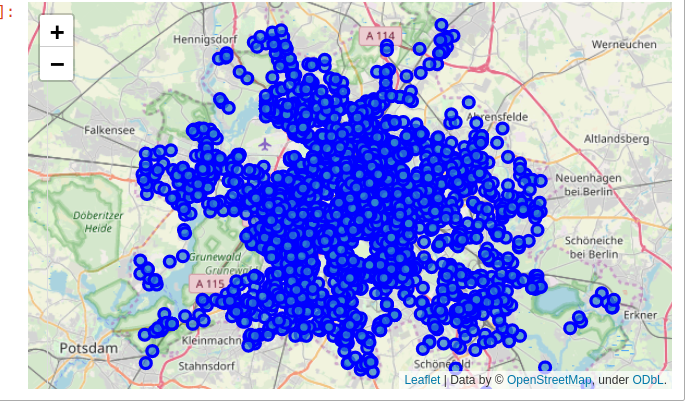

In [123]:

map_berlin = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(company_data['Lat'], company_data['Lon'], company_data['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)      
map_berlin
Image(filename='images/all_companies.png')

#### 3.1.2 Let's see the zipcode having above 50 companies

In [41]:
df_agg = company_data[['Ortsteil','Zipcode', 'Name']].groupby(['Ortsteil','Zipcode']).count()
df_agg = df_agg.reset_index()
df_agg = df_agg.sort_values(by = "Name", ascending=False)
df_agg_50 = df_agg[df_agg["Name"]>50]
print("Shape :", df_agg_50.shape)
df_agg_50

Shape : (27, 3)


Ortsteil  Zipcode  Name
93             Mitte    10117   516
180      Wilmersdorf    10719   187
94             Mitte    10178   164
92             Mitte    10115   149
16    Charlottenburg    10623   125
95             Mitte    10179   121
61         Kreuzberg    10785   120
120  Prenzlauer Berg    10119   109
177      Wilmersdorf    10707    93
121  Prenzlauer Berg    10405    86
64         Kreuzberg    10969    85
66         Kreuzberg    10999    76
65         Kreuzberg    10997    76
15    Charlottenburg    10587    76
46          Halensee    10709    72
42         Grunewald    10711    68
34    Friedrichshain    10245    65
142       Schöneberg    10787    65
88           Marzahn    12681    65
143       Schöneberg    10789    63
1          Adlershof    12489    63
19    Charlottenburg    10629    63
7        Borsigwalde    13509    59
33    Friedrichshain    10243    59
8              Britz    12099    55
85       Marienfelde    12277    53
63         Kreuzberg    10963    52

In [42]:
# Get zipcode cordinates for zipcodes having above 50 companies

import string
import random

zip50 = df_agg_50["Zipcode"].values.tolist()

In [43]:
def find_latlon(zipcodes):
    ll_array = {}
    N = 3
    try:
        while len(ll_array.keys()) != len(zipcodes):
            for zipcode in zipcodes:
                res = ''.join(random.choices(string.ascii_uppercase +string.digits, k = N))
                geolocator = Nominatim(user_agent="{}_explorer".format(res))
                print(res)
                ll = []
                location_ = geolocator.geocode(zipcode)
                latitude_ = location_.latitude
                longitude_ = location_.longitude
                ll.append(latitude_)
                ll.append(longitude_)
                print(ll)
                ll_array[zipcode]= ll
    except Exception as e:
        print(e)
    finally:
        return ll_array

In [44]:
ll_array = find_latlon(zip50)
ll_array

CPC
[52.5223502, 13.3957345]
JWK
[52.4982762, 13.326013717599]
BBU
[52.52027755, 13.4047296223029]
X5C
[52.53195385, 13.3838001271759]
HTP
[52.5076454, 13.3335358]
DR0
[52.5136696, 13.4151943247728]
VND
[52.5050416, 13.3628463833447]
C6Q
[52.5301255, 13.4055081798411]
2MU
[52.4974608163396, 13.3139679031293]
RVI
[52.5344546914201, 13.4237892210062]
Z2W
[52.5023686, 13.4022649715186]
TW7
[52.5000125, 13.4170384]
HXO
[52.500838, 13.4397641163031]
2M6
[52.5174138, 13.3068805]
EMH
[52.49401945, 13.3030473222654]
6P5
[52.4984325, 13.2854946]
MUH
[52.5047110103693, 13.4620418614745]
4AY
[52.5044929954553, 13.346125454071]
M39
Service not available


{10117: [52.5223502, 13.3957345],
 10719: [52.4982762, 13.326013717599],
 10178: [52.52027755, 13.4047296223029],
 10115: [52.53195385, 13.3838001271759],
 10623: [52.5076454, 13.3335358],
 10179: [52.5136696, 13.4151943247728],
 10785: [52.5050416, 13.3628463833447],
 10119: [52.5301255, 13.4055081798411],
 10707: [52.4974608163396, 13.3139679031293],
 10405: [52.5344546914201, 13.4237892210062],
 10969: [52.5023686, 13.4022649715186],
 10999: [52.5000125, 13.4170384],
 10997: [52.500838, 13.4397641163031],
 10587: [52.5174138, 13.3068805],
 10709: [52.49401945, 13.3030473222654],
 10711: [52.4984325, 13.2854946],
 10245: [52.5047110103693, 13.4620418614745],
 10787: [52.5044929954553, 13.346125454071]}

In [48]:
last_seen = list(ll_array.keys())[-1]
new_zip = find_latlon(zip50[zip50.index(last_seen)+1:])

P4F
[52.4287101, 13.5451564]
SBS
[52.5028499076973, 13.309441005157]
XOG
[52.591439227596, 13.2994248339698]
XTW
[52.5127617, 13.4264636]
32U
[52.4647344, 13.4032931865951]
RLX
[52.41541955, 13.3781799048634]
TS9
[52.5003045261237, 13.3824990465792]


In [49]:
# Update dictionaty of zip code lat and lon
ll_array.update(new_zip)
print(len(ll_array.keys()))

27


In [50]:
df_agg_50["ll"]= df_agg_50["Zipcode"].apply(lambda x : ll_array[x])

/home/prabhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_50_loc = pd.DataFrame(df_agg_50["ll"].values.tolist(), columns=["Lat", "Lon"])
df_agg_50 = df_agg_50.reset_index(drop=True)
df_50_loc = pd.concat([df_agg_50,df_50_loc], axis =1)

# 4. Evaluations

### 4.1. How many companies are located in each area? (i.e per zip code)

In [52]:
df_50_loc = df_50_loc.rename(columns={"Name":"Count"})
df_50_loc

Ortsteil  Zipcode  Count                                    ll  \
0             Mitte    10117    516              [52.5223502, 13.3957345]   
1       Wilmersdorf    10719    187         [52.4982762, 13.326013717599]   
2             Mitte    10178    164       [52.52027755, 13.4047296223029]   
3             Mitte    10115    149       [52.53195385, 13.3838001271759]   
4    Charlottenburg    10623    125              [52.5076454, 13.3335358]   
5             Mitte    10179    121        [52.5136696, 13.4151943247728]   
6         Kreuzberg    10785    120        [52.5050416, 13.3628463833447]   
7   Prenzlauer Berg    10119    109        [52.5301255, 13.4055081798411]   
8       Wilmersdorf    10707     93  [52.4974608163396, 13.3139679031293]   
9   Prenzlauer Berg    10405     86  [52.5344546914201, 13.4237892210062]   
10        Kreuzberg    10969     85        [52.5023686, 13.4022649715186]   
11        Kreuzberg    10999     76              [52.5000125, 13.4170384]   
12        Kreuzberg    10997     76         [52.500838, 13.4397641163031]   
13   Charlottenburg    10587     76              [52.5174138, 13.3068805]   
14         Halensee    10709     72       [52.49401945, 13.3030473222654]   
15        Grunewald    10711     68              [52.4984325, 13.2854946]   
16   Friedrichshain    10245     65  [52.5047110103693, 13.4620418614745]   
17       Schöneberg    10787     65   [52.5044929954553, 13.346125454071]   
18          Marzahn    12681     65              [52.5307082, 13.5223212]   
19       Schöneberg    10789     63        [52.5021475, 13.3380110476059]   
20        Adlershof    12489     63              [52.4287101, 13.5451564]   
21   Charlottenburg    10629     63   [52.5028499076973, 13.309441005157]   
22      Borsigwalde    13509     59   [52.591439227596, 13.2994248339698]   
23   Friedrichshain    10243     59              [52.5127617, 13.4264636]   
24            Britz    12099     55        [52.4647344, 13.4032931865951]   
25      Marienfelde    12277     53       [52.41541955, 13.3781799048634]   
26        Kreuzberg    10963     52  [52.5003045261237, 13.3824990465792]   

          Lat        Lon  
0   52.522350  13.395734  
1   52.498276  13.326014  
2   52.520278  13.404730  
3   52.531954  13.383800  
4   52.507645  13.333536  
5   52.513670  13.415194  
6   52.505042  13.362846  
7   52.530125  13.405508  
8   52.497461  13.313968  
9   52.534455  13.423789  
10  52.502369  13.402265  
11  52.500012  13.417038  
12  52.500838  13.439764  
13  52.517414  13.306881  
14  52.494019  13.303047  
15  52.498432  13.285495  
16  52.504711  13.462042  
17  52.504493  13.346125  
18  52.530708  13.522321  
19  52.502147  13.338011  
20  52.428710  13.545156  
21  52.502850  13.309441  
22  52.591439  13.299425  
23  52.512762  13.426464  
24  52.464734  13.403293  
25  52.415420  13.378180  
26  52.500305  13.382499

### 4.1.1 How many companies are located in each area? (i.e Ortsteil)

In [109]:
grouped = df_50_loc.groupby('Ortsteil')["Count"].sum().reset_index()
grouped = grouped.sort_values('Count', ascending=False)
grouped = grouped.reset_index()
grouped

index         Ortsteil  Count
0      10            Mitte    950
1       7        Kreuzberg    409
2      13      Wilmersdorf    280
3       3   Charlottenburg    264
4      11  Prenzlauer Berg    195
5      12       Schöneberg    128
6       4   Friedrichshain    124
7       6         Halensee     72
8       5        Grunewald     68
9       9          Marzahn     65
10      0        Adlershof     63
11      1      Borsigwalde     59
12      2            Britz     55
13      8      Marienfelde     53

#### Let's visualize the company clusters

I have selected an index number as their cluster number of each area. We can see clusters of company locations on the map with different colors.

In [54]:
grouped_cp_data = company_data.merge(grouped, left_on="Ortsteil", right_on="Ortsteil")

In [55]:
grouped_cp_data.head()

Name                    Street  Zipcode  \
0        (KA) Kraft Automobile GmbH             Wexstrasse 15    10715   
1                     1000eyes GmbH  Joachimstaler Strasse 12    10719   
2       2001 Medizin + Service GmbH         Kurfürstendamm 33    10719   
3  A + F Franchise Investments GmbH         Uhlandstrasse 173    10719   
4             A.D. Real Estate GmbH        Xantener Strasse 4    10707   

     City     Lat     Lon                                     Branch  \
0  Berlin  52.479  13.336   Autohandel und Kfz-Handel (Nutzfahrzeuge   
1  Berlin  52.503  13.331  Ingenieurbüros für technische Fachplanung   
2  Berlin  52.502  13.325  Ingenieurbüros für technische Fachplanung   
3  Berlin  52.502  13.325                       Unternehmensberatung   
4  Berlin  52.499  13.312    Kauf und Verkauf von eigenen Immobilien   

      Ortsteil  index  Count  
0  Wilmersdorf     13    280  
1  Wilmersdorf     13    280  
2  Wilmersdorf     13    280  
3  Wilmersdorf     13    280  
4  Wilmersdorf     13    280

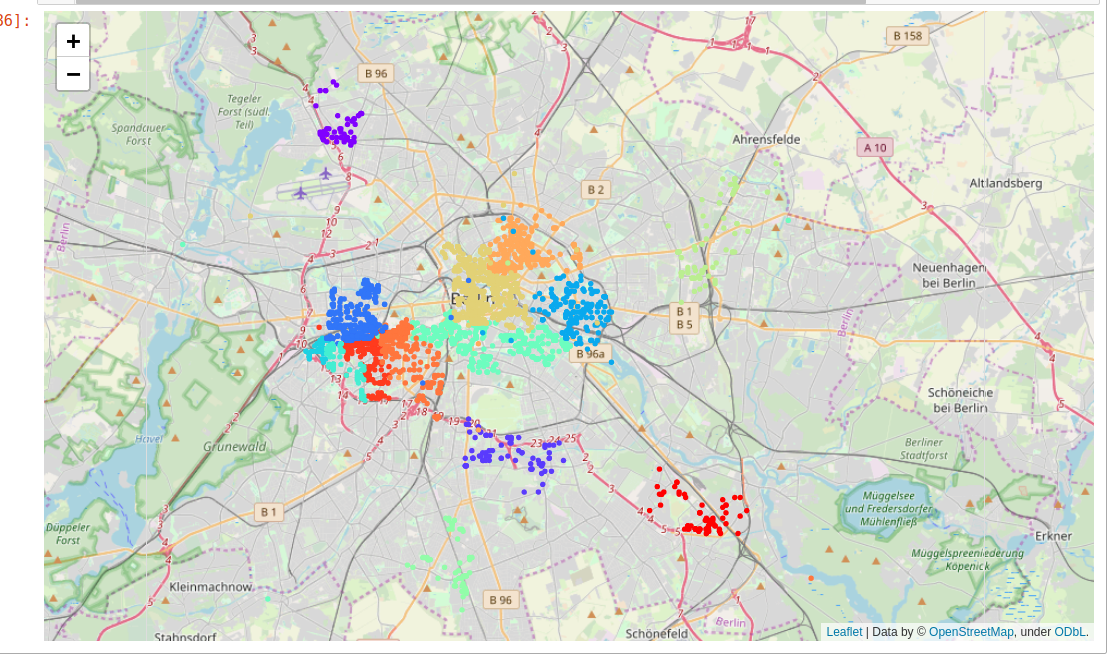

In [119]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters based on index numbers of grouped dataframe
x = grouped.index.to_numpy()
ys = [i + x + (i*x)**2 for i in range(14)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped_cp_data['Lat'], grouped_cp_data['Lon'], grouped_cp_data['Ortsteil'], grouped_cp_data['index']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
Image(filename='images/clusters of companies.png')

After having data analysis of company data, it describes, neighborhood "Mitte" has the highest number of companies. "Kreuzberg" has the second-highest number of companies. However, "Schöneberg" and "Friedrichshain" are in the top 7 positions. "Mitte" area is situated in central Berlin and mostly in its old town, it is traversed by the river Spree. Also, most of the city tourist attractions are situated in Mitte. Hence, it does sound like an ideal location for having a restaurant or an office there. However, it might expensive. Let's continue with the further analysis of average rental prices and which types of venues have existed in each neighborhood. 

## 4.2 Average rental prices for a given area

In [113]:
best_location_prices = merged.loc[grouped.Ortsteil.values.tolist()]["€/m²"]
best_location_prices = best_location_prices.reset_index()
best_location_prices = best_location_prices.groupby("Ortsteil")["€/m²"].mean().reset_index()
best_location_prices = best_location_prices.sort_values("€/m²")

best_location_prices

Ortsteil   €/m²
9           Marzahn   8.06
1       Borsigwalde   9.15
2             Britz   9.40
0         Adlershof  12.51
12       Schöneberg  14.47
13      Wilmersdorf  14.73
6          Halensee  14.94
3    Charlottenburg  15.64
4    Friedrichshain  16.00
5         Grunewald  16.51
7         Kreuzberg  16.54
10            Mitte  17.27
11  Prenzlauer Berg  17.36
8       Marienfelde  19.82

In [58]:
# Avarage rental price in per neighborhood
import matplotlib.pyplot as plt
import seaborn as sns

avg_rp_nei = grouped.merge(best_location_prices, left_on="Ortsteil", right_on="Ortsteil")
avg_rp_nei = avg_rp_nei.sort_values("€/m²")
avg_rp_nei = avg_rp_nei.reset_index(drop=True)
fig, ax1 = plt.subplots(figsize=(20, 7))
sns.barplot(x='Ortsteil', y='Count', data=avg_rp_nei, ax=ax1)
sns.despine(fig)

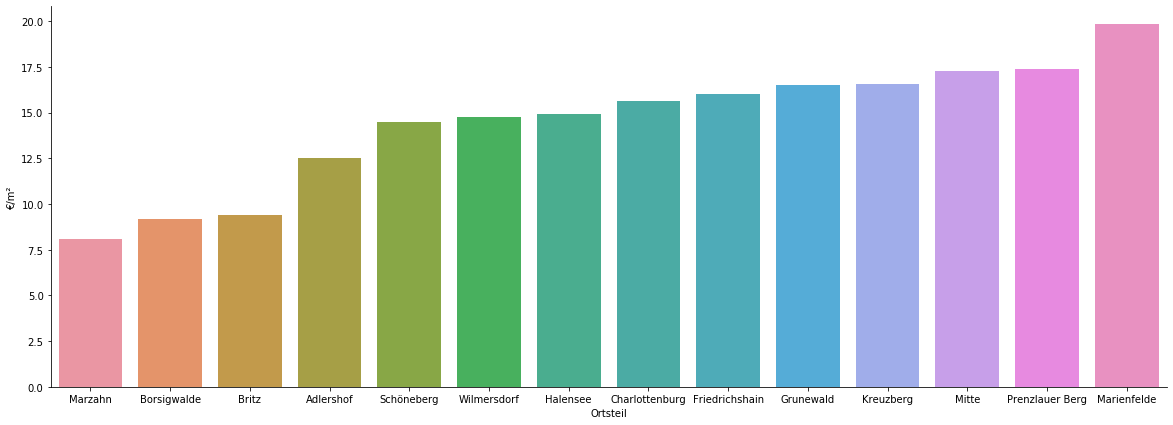

In [59]:
fig, ax1 = plt.subplots(figsize=(20, 7))
sns.barplot(x='Ortsteil', y='€/m²', data=avg_rp_nei, ax=ax1)
sns.despine(fig)

## 4.3 Rank the neighborhoods based on having lowest price and highest companies

It feels it is the best approach for opening a restaurant or an office based on statistics of data. Rule of thumb, having the lowest price, maximizing the number of companies around the restaurant/office helps to thrive a business. Therefore this logic helps to rank each location to select the top 7 places for any business in an ideal place.

In [60]:
from sklearn.preprocessing import minmax_scale

In [61]:
sc = minmax_scale(avg_rp_nei[["Count", "€/m²"]])
sc_df = pd.DataFrame(sc, columns=["Wei_Count", "Wei_price"])
sc_df["Wei_price"] = -(sc_df["Wei_price"]-1)
sc_df.loc[13,"Wei_price"] = 0

In [62]:
avg_rp_nei = pd.concat([avg_rp_nei,sc_df], axis =1)
avg_rp_nei["Rank"] = sc_df.sum(axis=1)
avg_rp_nei

index         Ortsteil  Count   €/m²  Wei_Count  Wei_price      Rank
0       9          Marzahn     65   8.06   0.013378   1.000000  1.013378
1       1      Borsigwalde     59   9.15   0.006689   0.907313  0.914002
2       2            Britz     55   9.40   0.002230   0.886054  0.888284
3       0        Adlershof     63  12.51   0.011148   0.621599  0.632747
4      12       Schöneberg    128  14.47   0.083612   0.454932  0.538544
5      13      Wilmersdorf    280  14.73   0.253066   0.432823  0.685889
6       6         Halensee     72  14.94   0.021182   0.414966  0.436148
7       3   Charlottenburg    264  15.64   0.235229   0.355442  0.590671
8       4   Friedrichshain    124  16.00   0.079153   0.324830  0.403983
9       5        Grunewald     68  16.51   0.016722   0.281463  0.298185
10      7        Kreuzberg    409  16.54   0.396878   0.278912  0.675790
11     10            Mitte    950  17.27   1.000000   0.216837  1.216837
12     11  Prenzlauer Berg    195  17.36   0.158305   0.209184  0.367489
13      8      Marienfelde     53  19.82   0.000000   0.000000  0.000000

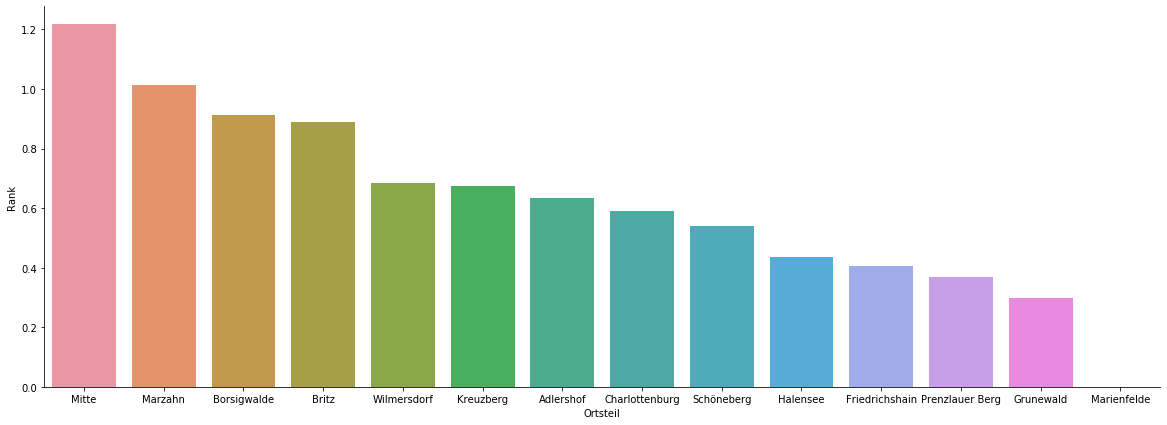

In [64]:
avg_rp_nei = avg_rp_nei.sort_values("Rank", ascending=False)
fig, ax1 = plt.subplots(figsize=(20, 7))
sns.barplot(x='Ortsteil', y='Rank',data=avg_rp_nei, ax=ax1)
sns.despine(fig)

#### Now, I have the ranks of each neighborhood, Let's conclude the places which are good for opening a new branch. Select top 7 best places.

In [65]:
top_7 = avg_rp_nei.head(7)
top_7

index     Ortsteil  Count   €/m²  Wei_Count  Wei_price      Rank
11     10        Mitte    950  17.27   1.000000   0.216837  1.216837
0       9      Marzahn     65   8.06   0.013378   1.000000  1.013378
1       1  Borsigwalde     59   9.15   0.006689   0.907313  0.914002
2       2        Britz     55   9.40   0.002230   0.886054  0.888284
5      13  Wilmersdorf    280  14.73   0.253066   0.432823  0.685889
10      7    Kreuzberg    409  16.54   0.396878   0.278912  0.675790
3       0    Adlershof     63  12.51   0.011148   0.621599  0.632747

## 4.4 Grouping similar services of companies

In [66]:
# Filtering company dataset for top 7 locations. 
top_7_cp_data = company_data.merge(top_7, left_on="Ortsteil", right_on="Ortsteil")
top_7_cp_data.shape

(2054, 14)

In [67]:
x = top_7_cp_data.groupby(["Branch"])["Rank"].count().reset_index()
x[x["Rank"]>10].sort_values("Rank", ascending=False)["Rank"].sum()

1036

In [68]:
services_df = x[x["Rank"]>10].sort_values("Rank", ascending=False)
services_df = services_df.reset_index(drop=True)

In [69]:
services_df = services_df.reset_index()
services_df

index                                             Branch  Rank
0       0                               Unternehmensberatung   110
1       1                            Dienstleistungen a.n.g.    79
2       2                              Werbung und Marketing    58
3       3            Kauf und Verkauf von eigenen Immobilien    52
4       4            Holding- und Beteiligungsgesellschaften    50
5       5                                         Verwaltung    45
6       6                                    Sachverständige    43
7       7                  Immobilien-Vermittlung für Dritte    43
8       8  Verwaltung und Management von Unternehmen und ...    43
9       9          Sonstige wirtschaftliche Dienstleistungen    42
10     10           Softwareberatung und Softwareentwicklung    39
11     11                  Webdesign und IT-Dienstleistungen    32
12     12                                      Ausstellungen    26
13     13     Ingenieurbüros für bautechnische Gesamtplanung    24
14     14                           Internetdienstleistungen    22
15     15          Ingenieurbüros für technische Fachplanung    22
16     16                 Rechtsanwälte und Anwaltskanzleien    20
17     17                                Personalvermittlung    19
18     18  Internetfirmen und Softwarehäuser / Internetfi...    18
19     19         Fernsehsender und Radiosender (Produktion)    18
20     20                                      Versandhandel    17
21     21                   Immobilien-Verwaltung für Dritte    17
22     22                                   Hardwareberatung    17
23     23                   Reisebüros und Reiseveranstalter    16
24     24    Vermögensberater und sonstige Vermögensberatung    15
25     25             Werbung und Marketing / Werbeagenturen    15
26     26                          Public-Relations-Beratung    13
27     27                                    Hotels / Hotels    13
28     28                  Erwachsenenbildung und Unterricht    13
29     29                              Telefongesellschaften    13
30     30               Webhosting und Server Administration    13
31     31               Marktforschung und Meinungsforschung    12
32     32                                        Restaurants    12
33     33                       Architekturbüros/Architekten    12
34     34                                         Callcenter    11
35     35           Autohandel und Kfz-Handel (Nutzfahrzeuge    11
36     36  Architekturbüros für Hochbau und Innenarchitektur    11

##### Below we can see types of company's that are existed in top 7 areas. As an example, will show you for "Mitte" place , in similar way rest of areas can be drawn.

In [70]:
services_cp_data = top_7_cp_data.merge(services_df[["Branch","index"]], left_on="Branch", right_on="Branch")
pd.set_option('display.max_rows', 500)
grouped_services = services_cp_data.groupby(["Ortsteil","Branch"])["Name"].count().reset_index()
grouped_services = grouped_services.rename(columns={"Name":"Number of companies"})

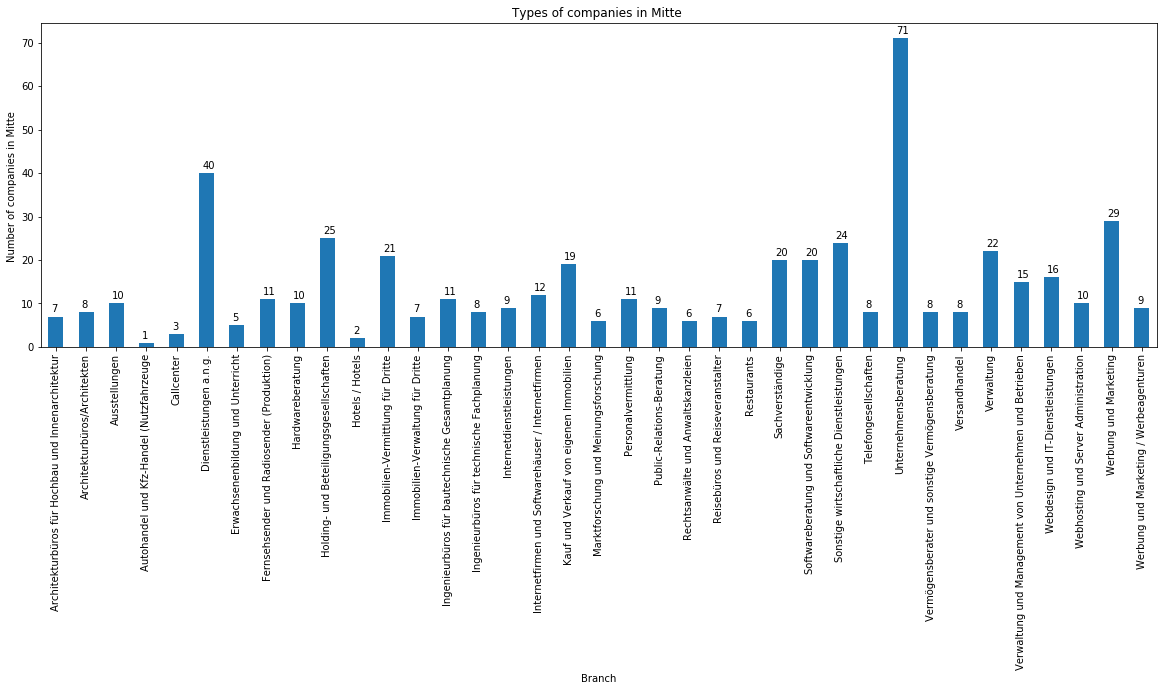

In [71]:
data_=grouped_services[grouped_services["Ortsteil"]=="Mitte"]

axes = data_.set_index("Branch")["Number of companies"].plot(kind='bar',subplots=True, figsize=(20,25))
for ax_ in axes:
    for i in ax_.patches:
        ax_.annotate(int(round(i.get_height())), (i.get_x() + 0.1, i.get_height() + 1))
plt.title("Types of companies in Mitte ")
plt.ylabel("Number of companies in Mitte ")
plt.subplots_adjust(bottom=0.7)
plt.savefig("images/types_company_mitte.png")

### As of now, I have selected an index number as their cluster number of each branch. We can see their locations on the map with different colors for each branch.

In [121]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters based on index numbers of grouped dataframe
x = services_df.index.to_numpy()
ys = [i + x + (i*x)**2 for i in x]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(services_cp_data['Lat'], services_cp_data['Lon'], services_cp_data['Branch'], services_cp_data['index_y']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## 4.5 Explore the type of shops are located near to each company

However, I will only go through the selected areas i.e top 7 places. Let's see 

#### For getting data from the Foursquare please run below code

```python
CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20191104' # Foursquare API version
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    new_data = []
    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        if count%10==0:
            print("Comapny :{}, Count :{}".format(name,count))
        count = count + 1
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)
                # make the GET request
        results = requests.get(url).json()
        new_data.append(results)
        
    return new_data
new_data_nearby = getNearbyVenues(names=no_data["Name"], latitudes=no_data["Company Latitude"],
                                  longitudes=no_data["Company Longitude"], radius=800)
```

### 4.5.1 Now write the code to run the above function on each company and create a new dataframe called nearby_venues.¶

In [73]:
# Extract data from Foursquare and return only relevant information for each nearby venue
import json
 
with open('data/venue_data.json') as f:
    nearby_venues = json.load(f)


In [74]:
services_cp_data.head()

Name                      Street  Zipcode  \
0         (KA) Kraft Automobile GmbH               Wexstrasse 15    10715   
1                    Auto Mivex GmbH            Bürgerstrasse 14    12347   
2  Volkswagen Automobile Berlin GmbH       Oberlandstrasse 40-41    12099   
3      Amore Automobile Moresco e.K.       Mariannenstrasse 9-10    10999   
4                          WKDA GmbH  Karl-Liebknecht-Strasse 34    10178   

     City     Lat     Lon                                    Branch  \
0  Berlin  52.479  13.336  Autohandel und Kfz-Handel (Nutzfahrzeuge   
1  Berlin  52.462  13.443  Autohandel und Kfz-Handel (Nutzfahrzeuge   
2  Berlin  52.464  13.413  Autohandel und Kfz-Handel (Nutzfahrzeuge   
3  Berlin  52.500  13.422  Autohandel und Kfz-Handel (Nutzfahrzeuge   
4  Berlin  52.526  13.415  Autohandel und Kfz-Handel (Nutzfahrzeuge   

      Ortsteil  index_x  Count   €/m²  Wei_Count  Wei_price      Rank  index_y  
0  Wilmersdorf       13    280  14.73   0.253066   0.432823  0.685889       35  
1        Britz        2     55   9.40   0.002230   0.886054  0.888284       35  
2        Britz        2     55   9.40   0.002230   0.886054  0.888284       35  
3    Kreuzberg        7    409  16.54   0.396878   0.278912  0.675790       35  
4        Mitte       10    950  17.27   1.000000   0.216837  1.216837       35

In [75]:
names=services_cp_data['Name'].values.tolist()
latitudes=services_cp_data['Lat'].values.tolist()
longitudes=services_cp_data['Lon'].values.tolist()

In [76]:
venues_list= []
for i in range(1036):
    item = nearby_venues[i]
    name = names[i]
    lat = latitudes[i]
    lon = longitudes[i]
    item_ = item["response"]
    if "groups" in item_.keys():
        results =  item_['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    else:
        venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])
venue_data = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
venue_data.columns = ['Name', 
              'Company Latitude', 
              'Company Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
venue_data

Name Company Latitude Company Longitude  \
0      (KA) Kraft Automobile GmbH           52.479            13.424   
1      (KA) Kraft Automobile GmbH           52.479            13.424   
2      (KA) Kraft Automobile GmbH           52.479            13.424   
3      (KA) Kraft Automobile GmbH           52.479            13.424   
4      (KA) Kraft Automobile GmbH           52.479            13.424   
...                           ...              ...               ...   
52617              ePortrait GmbH           52.520            13.424   
52618      managedhosting.de GmbH           52.508            13.424   
52619   paylogic Deutschland GmbH           52.525            13.424   
52620         INX Consulting GmbH           52.527            13.424   
52621    INX Netzwerktechnik GmbH           52.527            13.424   

                    Venue  Venue Latitude  Venue Longitude     Venue Category  
0               Bieberbau       52.479640        13.333733  German Restaurant  
1           EDEKA Schmidt       52.476985        13.332797        Supermarket  
2           Süßkramdealer       52.477275        13.330189        Candy Store  
3      Rudolph-Wilde-Park       52.482571        13.339849               Park  
4       Zig Zag Jazz Club       52.475245        13.340240          Jazz Club  
...                   ...             ...              ...                ...  
52617                None             NaN              NaN               None  
52618                None             NaN              NaN               None  
52619                None             NaN              NaN               None  
52620                None             NaN              NaN               None  
52621                None             NaN              NaN               None  

[52622 rows x 7 columns]

In [77]:
venue_data.head()

Name Company Latitude Company Longitude  \
0  (KA) Kraft Automobile GmbH           52.479            13.424   
1  (KA) Kraft Automobile GmbH           52.479            13.424   
2  (KA) Kraft Automobile GmbH           52.479            13.424   
3  (KA) Kraft Automobile GmbH           52.479            13.424   
4  (KA) Kraft Automobile GmbH           52.479            13.424   

                Venue  Venue Latitude  Venue Longitude     Venue Category  
0           Bieberbau       52.479640        13.333733  German Restaurant  
1       EDEKA Schmidt       52.476985        13.332797        Supermarket  
2       Süßkramdealer       52.477275        13.330189        Candy Store  
3  Rudolph-Wilde-Park       52.482571        13.339849               Park  
4   Zig Zag Jazz Club       52.475245        13.340240          Jazz Club

In [78]:
# Filter none valued rows from the data.
no_data  = venue_data[venue_data["Venue"].isna()][["Name", "Company Latitude", "Company Longitude"]]
no_data.head()

Name Company Latitude Company Longitude
27928                       WESTGRUND AG           52.502            13.424
52172                   Coded Crush GmbH           52.500            13.424
52173  FlavourSys Geschäftsführungs GmbH           52.503            13.424
52174           FlavourSys GmbH + Co. KG           52.503            13.424
52175                    Gradleware GmbH           52.497            13.424

In [79]:
venue_data = venue_data.dropna()
print(venue_data.shape)
venue_data.head()

(52171, 7)


Name Company Latitude Company Longitude  \
0  (KA) Kraft Automobile GmbH           52.479            13.424   
1  (KA) Kraft Automobile GmbH           52.479            13.424   
2  (KA) Kraft Automobile GmbH           52.479            13.424   
3  (KA) Kraft Automobile GmbH           52.479            13.424   
4  (KA) Kraft Automobile GmbH           52.479            13.424   

                Venue  Venue Latitude  Venue Longitude     Venue Category  
0           Bieberbau       52.479640        13.333733  German Restaurant  
1       EDEKA Schmidt       52.476985        13.332797        Supermarket  
2       Süßkramdealer       52.477275        13.330189        Candy Store  
3  Rudolph-Wilde-Park       52.482571        13.339849               Park  
4   Zig Zag Jazz Club       52.475245        13.340240          Jazz Club

If you like to save the data, please run below code.
```python
with open("data/new_data_nearby.json","w") as f:
    json.dump(new_data_nearby, f)
```

In [80]:
with open("data/new_data_nearby.json", "r") as f:
    new_data_nearby = json.load(f)

In [81]:
new_data_venues_list= []
new_names = no_data["Name"].values.tolist()
new_latitudes=no_data["Company Latitude"].values.tolist()
new_longitudes=no_data["Company Longitude"].values.tolist()
for i in range(len(new_data_nearby)):
    item = new_data_nearby[i]
    name = new_names[i]
    lat = new_latitudes[i]
    lon = new_longitudes[i]
    item_ = item["response"]
    if "groups" in item_.keys():
        results =  item_['groups'][0]['items']
        new_data_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    else:
        new_data_venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])
new_venue_data = pd.DataFrame([item for venue_list in new_data_venues_list for item in venue_list])
new_venue_data.columns = ['Name', 
              'Company Latitude', 
              'Company Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
new_venue_data

Name Company Latitude Company Longitude  \
0                   WESTGRUND AG           52.502            13.424   
1                   WESTGRUND AG           52.502            13.424   
2                   WESTGRUND AG           52.502            13.424   
3                   WESTGRUND AG           52.502            13.424   
4                   WESTGRUND AG           52.502            13.424   
...                          ...              ...               ...   
38963             ePortrait GmbH           52.520            13.424   
38964     managedhosting.de GmbH           52.508            13.424   
38965  paylogic Deutschland GmbH           52.525            13.424   
38966        INX Consulting GmbH           52.527            13.424   
38967   INX Netzwerktechnik GmbH           52.527            13.424   

                         Venue  Venue Latitude  Venue Longitude  \
0                  Yellow Yoga       52.500688        13.423982   
1      Kunstquartier Bethanien       52.503864        13.424628   
2              Modern Graphics       52.500748        13.421465   
3                       Co'm Á       52.500385        13.422654   
4             Companion Coffee       52.501148        13.421062   
...                        ...             ...              ...   
38963                     None             NaN              NaN   
38964                     None             NaN              NaN   
38965                     None             NaN              NaN   
38966                     None             NaN              NaN   
38967                     None             NaN              NaN   

         Venue Category  
0           Yoga Studio  
1           Art Gallery  
2            Comic Shop  
3      Sushi Restaurant  
4           Coffee Shop  
...                 ...  
38963              None  
38964              None  
38965              None  
38966              None  
38967              None  

[38968 rows x 7 columns]

In [82]:
na_data = new_venue_data[new_venue_data["Venue Category"].isna()]
print(na_data.shape)
na_data.head()

(24, 7)


Name Company Latitude  \
38944                          Ressourcenmangel GmbH           52.499   
38945         Short Cuts GmbH design + kommunikation           52.491   
38946                                      Aperto AG           52.528   
38947  DIEMEDIAFABRIK Agentur für Mediaberatung GmbH           52.535   
38948                           Dieckertschmidt GmbH           52.525   

      Company Longitude Venue  Venue Latitude  Venue Longitude Venue Category  
38944            13.424  None             NaN              NaN           None  
38945            13.424  None             NaN              NaN           None  
38946            13.424  None             NaN              NaN           None  
38947            13.424  None             NaN              NaN           None  
38948            13.424  None             NaN              NaN           None

In [83]:
new_venue_data = new_venue_data.dropna()
print(new_venue_data.shape)
new_venue_data.tail()

(38944, 7)


Name Company Latitude Company Longitude  \
38939  PaketPLUS Marketing GmbH           52.492            13.424   
38940  PaketPLUS Marketing GmbH           52.492            13.424   
38941  PaketPLUS Marketing GmbH           52.492            13.424   
38942  PaketPLUS Marketing GmbH           52.492            13.424   
38943  PaketPLUS Marketing GmbH           52.492            13.424   

              Venue  Venue Latitude  Venue Longitude      Venue Category  
38939      La Lucha       52.496135        13.422411  Mexican Restaurant  
38940     Goldmarie       52.494677        13.415562                Café  
38941         Vater       52.486770        13.428812                 Bar  
38942        Kaduka       52.488115        13.430048                 Bar  
38943  Villa di Wow       52.495279        13.429765         Pizza Place

In [88]:
with open("data/na_data_nearby.json","r") as f:
    na_data_nearby = json.load(f)

In [89]:
na_data_venues_list= []
na_names = na_data["Name"].values.tolist()
na_latitudes=na_data["Company Latitude"].values.tolist()
na_longitudes=na_data["Company Longitude"].values.tolist()
for i in range(len(na_data_nearby)):
    item = na_data_nearby[i]
    name = na_names[i]
    lat = na_latitudes[i]
    lon = na_longitudes[i]
    item_ = item["response"]
    if "groups" in item_.keys():
        results =  item_['groups'][0]['items']
        na_data_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    else:
        na_data_venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])
na_venue_data = pd.DataFrame([item for venue_list in na_data_venues_list for item in venue_list])
na_venue_data.columns = ['Name', 
              'Company Latitude', 
              'Company Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
na_venue_data

Name Company Latitude Company Longitude  \
0        Ressourcenmangel GmbH           52.499            13.424   
1        Ressourcenmangel GmbH           52.499            13.424   
2        Ressourcenmangel GmbH           52.499            13.424   
3        Ressourcenmangel GmbH           52.499            13.424   
4        Ressourcenmangel GmbH           52.499            13.424   
...                        ...              ...               ...   
2196  INX Netzwerktechnik GmbH           52.527            13.424   
2197  INX Netzwerktechnik GmbH           52.527            13.424   
2198  INX Netzwerktechnik GmbH           52.527            13.424   
2199  INX Netzwerktechnik GmbH           52.527            13.424   
2200  INX Netzwerktechnik GmbH           52.527            13.424   

                                 Venue  Venue Latitude  Venue Longitude  \
0                          Yellow Yoga       52.500688        13.423982   
1                               Basmah       52.498266        13.421194   
2                             Core Tex       52.499523        13.425441   
3                    Alimentari e Vini       52.499072        13.421806   
4                              Goldies       52.499721        13.425051   
...                                ...             ...              ...   
2196           Caramello Artisan Pizza       52.532130        13.431426   
2197                    Old Town Hotel       52.532429        13.427404   
2198               Café Tous Les Jours       52.531966        13.431387   
2199                              Watt       52.531550        13.415649   
2200  Caramello - Ice & Coffee & Pizza       52.532172        13.431427   

            Venue Category  
0              Yoga Studio  
1       African Restaurant  
2              Record Shop  
3             Gourmet Shop  
4     Fast Food Restaurant  
...                    ...  
2196           Pizza Place  
2197        Boarding House  
2198                  Café  
2199              Dive Bar  
2200        Ice Cream Shop  

[2201 rows x 7 columns]

Due to API limitation of Foursquare, I split the dataset int to 3 parts, finally, I was able to get all the required information. Let's combine the venue_data, new_venue_data and na_venue_data

In [91]:
venue_data = pd.concat([venue_data, new_venue_data, na_venue_data], axis=0)
venue_data = venue_data.reset_index(drop=True)
print(venue_data.shape)
venue_data.tail()

(93316, 7)


Name Company Latitude Company Longitude  \
93311  INX Netzwerktechnik GmbH           52.527            13.424   
93312  INX Netzwerktechnik GmbH           52.527            13.424   
93313  INX Netzwerktechnik GmbH           52.527            13.424   
93314  INX Netzwerktechnik GmbH           52.527            13.424   
93315  INX Netzwerktechnik GmbH           52.527            13.424   

                                  Venue  Venue Latitude  Venue Longitude  \
93311           Caramello Artisan Pizza       52.532130        13.431426   
93312                    Old Town Hotel       52.532429        13.427404   
93313               Café Tous Les Jours       52.531966        13.431387   
93314                              Watt       52.531550        13.415649   
93315  Caramello - Ice & Coffee & Pizza       52.532172        13.431427   

       Venue Category  
93311     Pizza Place  
93312  Boarding House  
93313            Café  
93314        Dive Bar  
93315  Ice Cream Shop

#### let's analyse the venue data, categories of venue data near to each company.

In [92]:
# Let's check how many venues were returned for each company
venue_data.groupby("Name").count()

Company Latitude  \
Name                                                                  
(KA) Kraft Automobile GmbH                                       51   
1000eyes GmbH                                                   100   
12designer GmbH                                                 100   
2001 Medizin + Service GmbH                                     100   
213 Gesellschaft für Besseres Wohnen mbH                        100   
...                                                             ...   
xailabs GmbH                                                    100   
yd.yourdelivery GmbH                                            100   
zappmedia GmbH                                                  100   
zischlermann filmproduktion GmbH                                100   
ÄRZTEFINANZZENTRUM BERLIN UG (haftungsbeschränkt)               100   

                                                   Company Longitude  Venue  \
Name                                                                          
(KA) Kraft Automobile GmbH                                        51     51   
1000eyes GmbH                                                    100    100   
12designer GmbH                                                  100    100   
2001 Medizin + Service GmbH                                      100    100   
213 Gesellschaft für Besseres Wohnen mbH                         100    100   
...                                                              ...    ...   
xailabs GmbH                                                     100    100   
yd.yourdelivery GmbH                                             100    100   
zappmedia GmbH                                                   100    100   
zischlermann filmproduktion GmbH                                 100    100   
ÄRZTEFINANZZENTRUM BERLIN UG (haftungsbeschränkt)                100    100   

                                                   Venue Latitude  \
Name                                                                
(KA) Kraft Automobile GmbH                                     51   
1000eyes GmbH                                                 100   
12designer GmbH                                               100   
2001 Medizin + Service GmbH                                   100   
213 Gesellschaft für Besseres Wohnen mbH                      100   
...                                                           ...   
xailabs GmbH                                                  100   
yd.yourdelivery GmbH                                          100   
zappmedia GmbH                                                100   
zischlermann filmproduktion GmbH                              100   
ÄRZTEFINANZZENTRUM BERLIN UG (haftungsbeschränkt)             100   

                                                   Venue Longitude  \
Name                                                                 
(KA) Kraft Automobile GmbH                                      51   
1000eyes GmbH                                                  100   
12designer GmbH                                                100   
2001 Medizin + Service GmbH                                    100   
213 Gesellschaft für Besseres Wohnen mbH                       100   
...                                                            ...   
xailabs GmbH                                                   100   
yd.yourdelivery GmbH                                           100   
zappmedia GmbH                                                 100   
zischlermann filmproduktion GmbH                               100   
ÄRZTEFINANZZENTRUM BERLIN UG (haftungsbeschränkt)              100   

                                                   Venue Category  
Name                                                               
(KA) Kraft Automobile GmbH                                     51  
1000eyes GmbH                                                 100  
12designer GmbH   

In [93]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(venue_data['Venue Category'].unique())))
print(venue_data['Venue Category'].unique())

There are 354 uniques categories.
['German Restaurant' 'Supermarket' 'Candy Store' 'Park' 'Jazz Club'
 'Trattoria/Osteria' 'Italian Restaurant' 'Café' 'Organic Grocery'
 'Greek Restaurant' 'Fountain' 'Garden' 'Vietnamese Restaurant' 'Bakery'
 'Seafood Restaurant' 'Doner Restaurant' 'Bistro' 'Food & Drink Shop'
 'Coffee Shop' 'Cocktail Bar' 'Ice Cream Shop' 'Hotel' 'Indian Restaurant'
 'Indie Movie Theater' 'Middle Eastern Restaurant' 'Mexican Restaurant'
 'Thai Restaurant' 'Plaza' 'Gas Station' 'Kids Store' 'Bar'
 'Farmers Market' 'Ukrainian Restaurant' 'Pharmacy' 'Metro Station'
 'Restaurant' 'Dessert Shop' 'Laser Tag' 'Market' 'Gym / Fitness Center'
 'Historic Site' 'Turkish Restaurant' 'Drugstore' 'Hardware Store'
 'Pizza Place' 'Motel' 'Motorcycle Shop' 'Big Box Store' 'Bus Stop'
 'Grocery Store' 'Shopping Mall' 'Harbor / Marina' 'Intersection'
 'Taverna' 'Skating Rink' 'Soccer Field' 'Film Studio'
 'Miscellaneous Shop' 'Yoga Studio' 'African Restaurant'
 'General Entertainment' 'C

### 4.5.2 Explore unique categories in top 7 areas

Here, I am going to use the knowledge of venue_data and the top 7 areas having a minimum of 10 company's which belongs to a particular branch in each area. I will walk you through the top 7 areas having different types of venue categories

Now that I have valuable information on each company i.e rental price, it's rank wise neighborhood preference, nearby venue categories, Zipcode, and neighborhood name. Based on this information, we will do further analysis. Also, we can cluster the company's that are similar in spatial data analysis. This may give a broad idea for opening a restaurant, whether a similar restaurant already opened or not. In terms of company services(i.e branch wise) which types of venue categories have existed. Eventually, these kinds of information reveal an ideal location for having a new office/restaurant or relocation of an existed branch.


In [94]:
# Assigning company zip code and Ortsteil
venue_data_ortsteil = venue_data.merge(services_cp_data[["Name", "Zipcode", "Ortsteil","€/m²","Branch","Rank"]],
                                      left_on="Name",right_on="Name")
venue_data_ortsteil.head()

Name Company Latitude Company Longitude  \
0  (KA) Kraft Automobile GmbH           52.479            13.424   
1  (KA) Kraft Automobile GmbH           52.479            13.424   
2  (KA) Kraft Automobile GmbH           52.479            13.424   
3  (KA) Kraft Automobile GmbH           52.479            13.424   
4  (KA) Kraft Automobile GmbH           52.479            13.424   

                Venue  Venue Latitude  Venue Longitude     Venue Category  \
0           Bieberbau       52.479640        13.333733  German Restaurant   
1       EDEKA Schmidt       52.476985        13.332797        Supermarket   
2       Süßkramdealer       52.477275        13.330189        Candy Store   
3  Rudolph-Wilde-Park       52.482571        13.339849               Park   
4   Zig Zag Jazz Club       52.475245        13.340240          Jazz Club   

   Zipcode     Ortsteil   €/m²                                    Branch  \
0    10715  Wilmersdorf  14.73  Autohandel und Kfz-Handel (Nutzfahrzeuge   
1    10715  Wilmersdorf  14.73  Autohandel und Kfz-Handel (Nutzfahrzeuge   
2    10715  Wilmersdorf  14.73  Autohandel und Kfz-Handel (Nutzfahrzeuge   
3    10715  Wilmersdorf  14.73  Autohandel und Kfz-Handel (Nutzfahrzeuge   
4    10715  Wilmersdorf  14.73  Autohandel und Kfz-Handel (Nutzfahrzeuge   

       Rank  
0  0.685889  
1  0.685889  
2  0.685889  
3  0.685889  
4  0.685889

### 4.5.2.1 As a sample example, we will check with the Mitte location

In [95]:
mitte_venue = venue_data_ortsteil[venue_data_ortsteil["Ortsteil"]=="Mitte"]
mitte_venue_grouped = mitte_venue.groupby("Venue Category").count()["Name"].reset_index()
mitte_venue_grouped = mitte_venue_grouped.rename(columns={"Name":"Count"})
mitte_venue_grouped = mitte_venue_grouped.sort_values("Count", ascending= False).head(25)


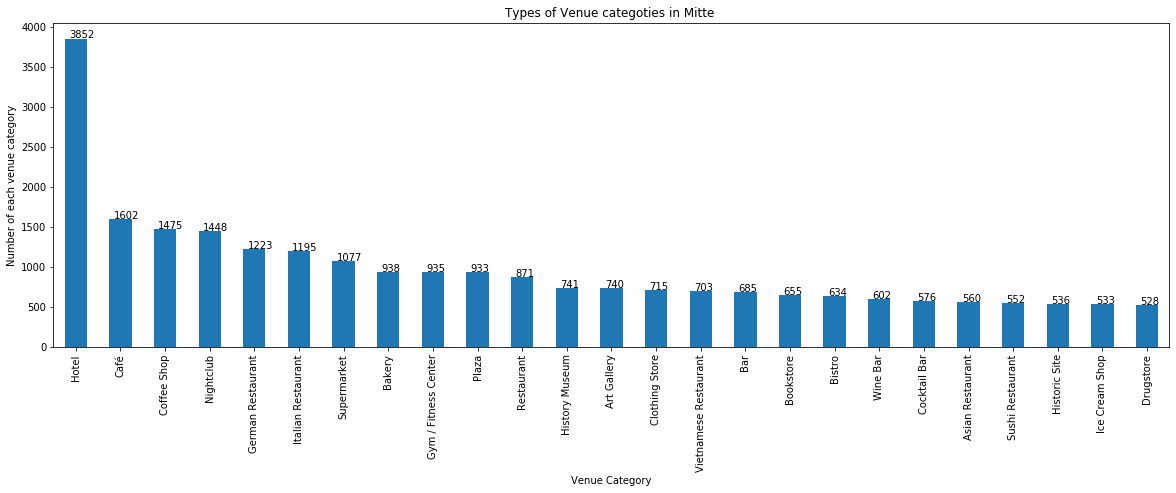

In [97]:
# This same plot can also be drwan for other areas too.
axes = mitte_venue_grouped.set_index("Venue Category")["Count"].plot(kind='bar',subplots=True, figsize=(20,25))
for ax_ in axes:
    for i in ax_.patches:
        ax_.annotate(int(round(i.get_height())), (i.get_x() + 0.1, i.get_height() + 2))
plt.title("Types of Venue categoties in Mitte ")
plt.ylabel("Number of each venue category")
plt.subplots_adjust(bottom=0.7)
plt.savefig("images/types_venues_mitte.png")

### 4.5.2.2 Let's see what kind of venue categories were surrounded for branch wise company.

I will select "Unternehmensberatung" 
since more companies were stated in this branch. This data exploration
might give a good idea of what makes a specific type of company in a particular location i.e having types of venue categories.

In [98]:
branch_venue_data = venue_data_ortsteil[venue_data_ortsteil["Branch"]=="Unternehmensberatung"]
branch_venue_grouped = branch_venue_data.groupby("Venue Category").count()["Name"].reset_index()
branch_venue_grouped = branch_venue_grouped.rename(columns={"Name":"Count"})
branch_venue_grouped = branch_venue_grouped.sort_values("Count", ascending=False).head(25)
branch_venue_grouped

Venue Category  Count
134                          Hotel    930
45                            Café    423
116              German Restaurant    360
146             Italian Restaurant    322
63                     Coffee Shop    315
209                          Plaza    206
221                     Restaurant    194
14                          Bakery    189
6                      Art Gallery    179
282          Vietnamese Restaurant    171
16                             Bar    168
129                 History Museum    161
280  Vegetarian / Vegan Restaurant    157
61                  Clothing Store    155
119                   Gourmet Shop    154
31                       Bookstore    150
62                    Cocktail Bar    146
123           Gym / Fitness Center    144
137                 Ice Cream Shop    132
286                       Wine Bar    132
69                    Concert Hall    122
256                    Supermarket    122
266                        Theater    118
91                       Drugstore    117
147            Japanese Restaurant    110

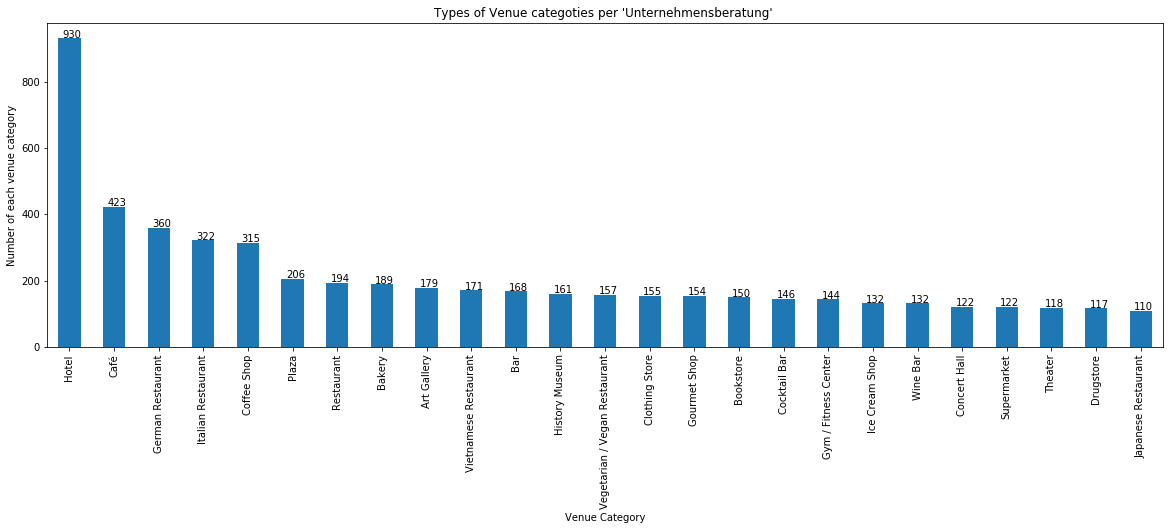

In [99]:
# This same plot can also be drwan for other branches too.
axes = branch_venue_grouped.set_index("Venue Category")["Count"].plot(kind='bar',subplots=True, figsize=(20,25))
for ax_ in axes:
    for i in ax_.patches:
        ax_.annotate(int(round(i.get_height())), (i.get_x() + 0.1, i.get_height() + 2))
plt.title("Types of Venue categoties per 'Unternehmensberatung' ")
plt.ylabel("Number of each venue category")
plt.subplots_adjust(bottom=0.7)
plt.savefig("images/types_venues_branch.png")

### 4.5.3 Cluster companies based on their nearby venue

In [100]:
# one hot encoding
venue_onehot = pd.get_dummies(venue_data[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
venue_onehot = pd.concat([venue_data["Name"], venue_onehot], axis=1)
print(venue_onehot.shape)
venue_onehot.head()

(93316, 355)


Name  ATM  Adult Boutique  African Restaurant  \
0  (KA) Kraft Automobile GmbH    0               0                   0   
1  (KA) Kraft Automobile GmbH    0               0                   0   
2  (KA) Kraft Automobile GmbH    0               0                   0   
3  (KA) Kraft Automobile GmbH    0               0                   0   
4  (KA) Kraft Automobile GmbH    0               0                   0   

   American Restaurant  Antique Shop  Aquarium  Argentinian Restaurant  \
0                    0             0         0                       0   
1                    0             0         0                       0   
2                    0             0         0                       0   
3                    0             0         0                       0   
4                    0             0         0                       0   

   Art Gallery  Art Museum  ...  Waterfront  Whisky Bar  Windmill  Wine Bar  \
0            0           0  ...           0           0         0         0   
1            0           0  ...           0           0         0         0   
2            0           0  ...           0           0         0         0   
3            0           0  ...           0           0         0         0   
4            0           0  ...           0           0         0         0   

   Wine Shop  Winery  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0          0       0              0            0    0            0  
1          0       0              0            0    0            0  
2          0       0              0            0    0            0  
3          0       0              0            0    0            0  
4          0       0              0            0    0            0  

[5 rows x 355 columns]

In [101]:
venue_grouped = venue_onehot.groupby('Name').mean().reset_index()
print(venue_grouped.shape)
venue_grouped.head()

(1034, 355)


Name  ATM  Adult Boutique  \
0                (KA) Kraft Automobile GmbH  0.0             0.0   
1                             1000eyes GmbH  0.0             0.0   
2                           12designer GmbH  0.0             0.0   
3               2001 Medizin + Service GmbH  0.0             0.0   
4  213 Gesellschaft für Besseres Wohnen mbH  0.0             0.0   

   African Restaurant  American Restaurant  Antique Shop  Aquarium  \
0                 0.0                  0.0           0.0       0.0   
1                 0.0                  0.0           0.0       0.0   
2                 0.0                  0.0           0.0       0.0   
3                 0.0                  0.0           0.0       0.0   
4                 0.0                  0.0           0.0       0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  ...  Waterfront  \
0                     0.0         0.00        0.00  ...         0.0   
1                     0.0         0.01        0.02  ...         0.0   
2                     0.0         0.01        0.00  ...         0.0   
3                     0.0         0.01        0.01  ...         0.0   
4                     0.0         0.03        0.00  ...         0.0   

   Whisky Bar  Windmill  Wine Bar  Wine Shop  Winery  Women's Store  \
0         0.0       0.0       0.0       0.00     0.0           0.00   
1         0.0       0.0       0.0       0.01     0.0           0.01   
2         0.0       0.0       0.0       0.01     0.0           0.00   
3         0.0       0.0       0.0       0.02     0.0           0.01   
4         0.0       0.0       0.0       0.01     0.0           0.00   

   Yoga Studio  Zoo  Zoo Exhibit  
0         0.00  0.0         0.00  
1         0.00  0.0         0.02  
2         0.00  0.0         0.00  
3         0.00  0.0         0.00  
4         0.02  0.0         0.00  

[5 rows x 355 columns]

In [102]:
# Let's print each each company along with the top 10 most common venues
num_top_venues = 10

for company in venue_grouped['Name']:
    print("----"+company+"----")
    temp = venue_grouped[venue_grouped['Name'] == company].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----(KA) Kraft Automobile GmbH----
                venue  freq
0                Café  0.12
1         Supermarket  0.10
2    Greek Restaurant  0.06
3               Plaza  0.04
4     Organic Grocery  0.04
5  Italian Restaurant  0.04
6         Gas Station  0.02
7      Ice Cream Shop  0.02
8               Hotel  0.02
9              Bistro  0.02


----1000eyes GmbH----
                  venue  freq
0                 Hotel  0.15
1        Clothing Store  0.08
2         Movie Theater  0.04
3                  Café  0.04
4     German Restaurant  0.04
5    Italian Restaurant  0.03
6          Cocktail Bar  0.03
7           Zoo Exhibit  0.02
8   Monument / Landmark  0.02
9  Gym / Fitness Center  0.02


----12designer GmbH----
                   venue  freq
0                   Café  0.08
1                 Bakery  0.04
2                  Hotel  0.04
3                    Bar  0.04
4              Nightclub  0.03
5         Ice Cream Shop  0.03
6  Vietnamese Restaurant  0.03
7      German Restaurant  0.0

                venue  freq
0           Nightclub  0.10
1               Hotel  0.07
2                 Bar  0.05
3   German Restaurant  0.05
4    Sushi Restaurant  0.04
5  Italian Restaurant  0.04
6         Coffee Shop  0.04
7              Bistro  0.03
8         Supermarket  0.03
9              Bakery  0.03


----Alcendo Gesellschaft für Finanzplanung mbH----
                   venue  freq
0      German Restaurant  0.08
1                  Hotel  0.07
2     Italian Restaurant  0.07
3                 Bakery  0.03
4                   Café  0.03
5    Japanese Restaurant  0.03
6           Dessert Shop  0.03
7       Asian Restaurant  0.03
8  Vietnamese Restaurant  0.03
9           Gourmet Shop  0.03


----All you need GmbH----
                  venue  freq
0             Nightclub  0.09
1           Supermarket  0.05
2      Sushi Restaurant  0.03
3           Event Space  0.03
4                Bakery  0.03
5                Bistro  0.03
6    Chinese Restaurant  0.02
7                 Hotel  0.02


                  venue  freq
0                 Hotel  0.17
1                  Café  0.06
2           Coffee Shop  0.04
3  Gym / Fitness Center  0.03
4     German Restaurant  0.03
5                Bakery  0.03
6      Asian Restaurant  0.03
7                 Plaza  0.03
8        History Museum  0.03
9         Burrito Place  0.02


----BIT GmbH Berliner Institut für Technologietransfer----
                   venue  freq
0                 Bakery  0.10
1            Supermarket  0.08
2      German Restaurant  0.05
3                   Café  0.05
4                  Hotel  0.04
5       Greek Restaurant  0.04
6     Italian Restaurant  0.04
7  Vietnamese Restaurant  0.04
8           Burger Joint  0.03
9            Coffee Shop  0.03


----BKI Immobilien Vertriebs- + Verwaltungsgesellschaft mbH----
                    venue  freq
0            Tram Station  0.25
1         Automotive Shop  0.12
2  Furniture / Home Store  0.12
3               Cafeteria  0.06
4                    Café  0.06
5         

                   venue  freq
0      German Restaurant  0.08
1                  Hotel  0.07
2     Italian Restaurant  0.07
3                   Café  0.06
4            Supermarket  0.04
5           Dessert Shop  0.04
6                    Bar  0.03
7                 Bakery  0.03
8  Vietnamese Restaurant  0.02
9            Coffee Shop  0.02


----CATELLA Property Advisors GmbH----
                venue  freq
0               Hotel  0.16
1      Clothing Store  0.07
2   German Restaurant  0.06
3         Zoo Exhibit  0.04
4       Movie Theater  0.04
5                Café  0.04
6        Cocktail Bar  0.03
7          Art Museum  0.03
8  Italian Restaurant  0.03
9          Restaurant  0.02


----CATELLA Property Valuation GmbH----
                venue  freq
0               Hotel  0.16
1      Clothing Store  0.07
2   German Restaurant  0.06
3         Zoo Exhibit  0.04
4       Movie Theater  0.04
5                Café  0.04
6        Cocktail Bar  0.03
7          Art Museum  0.03
8  Italian Resta

                   venue  freq
0            Coffee Shop  0.06
1         Breakfast Spot  0.05
2           Cocktail Bar  0.05
3  Vietnamese Restaurant  0.04
4                 Bakery  0.04
5          Deli / Bodega  0.04
6               Wine Bar  0.03
7         Ice Cream Shop  0.03
8                   Café  0.03
9                  Hotel  0.03


----DBZ GmbH Deutsches Beckenboden Zentrum----
                           venue  freq
0                          Hotel  0.05
1                    Art Gallery  0.04
2                        Theater  0.04
3                         Hostel  0.03
4                      Bookstore  0.03
5            Japanese Restaurant  0.03
6              German Restaurant  0.03
7  Vegetarian / Vegan Restaurant  0.03
8                   Cocktail Bar  0.03
9                            Pub  0.03


----DCH Solar GmbH----
                venue  freq
0   German Restaurant  0.08
1               Hotel  0.08
2  Italian Restaurant  0.06
3                Café  0.05
4        Dessert

                           venue  freq
0                          Hotel  0.07
1              German Restaurant  0.04
2                           Café  0.03
3                          Plaza  0.03
4                        Theater  0.03
5                      Bookstore  0.03
6                         Museum  0.03
7  Vegetarian / Vegan Restaurant  0.03
8                 Clothing Store  0.03
9                       Wine Bar  0.02


----Doyle Dane Bernbach Realisation GmbH----
                  venue  freq
0                 Hotel  0.10
1  Gym / Fitness Center  0.06
2   Indie Movie Theater  0.04
3           Beer Garden  0.04
4    Italian Restaurant  0.03
5                  Park  0.03
6          Cocktail Bar  0.03
7           Supermarket  0.03
8           Coffee Shop  0.03
9              Fountain  0.03


----Dr. Kieburg Lasertech-Services GmbH----
             venue  freq
0             Café  0.16
1      Supermarket  0.11
2            Hotel  0.11
3       Restaurant  0.05
4  Auto Dealership  0.0

                venue  freq
0         Coffee Shop  0.06
1                 Bar  0.06
2        Cocktail Bar  0.05
3  Turkish Restaurant  0.05
4                Café  0.05
5   German Restaurant  0.04
6  Italian Restaurant  0.03
7              Bakery  0.03
8         Pizza Place  0.03
9   Korean Restaurant  0.03


----Faust Film + Projekt GmbH----
                       venue  freq
0                        Bar  0.14
1                Coffee Shop  0.07
2         Turkish Restaurant  0.06
3                       Café  0.05
4          Korean Restaurant  0.03
5  Middle Eastern Restaurant  0.03
6               Cocktail Bar  0.03
7                     Bakery  0.03
8                Record Shop  0.02
9            Organic Grocery  0.02


----Feedify GmbH----
                         venue  freq
0                        Hotel  0.13
1                  Supermarket  0.09
2           Italian Restaurant  0.07
3                       Bakery  0.04
4                    Drugstore  0.04
5                        P

                  venue  freq
0                  Café  0.15
1                 Hotel  0.11
2      Greek Restaurant  0.07
3     Korean Restaurant  0.04
4           IT Services  0.04
5     Trattoria/Osteria  0.04
6          Tram Station  0.04
7        Hardware Store  0.04
8  Gym / Fitness Center  0.04
9           Supermarket  0.04


----Gegenbauer Holding Verwaltung SE----
                           venue  freq
0                          Hotel  0.09
1              German Restaurant  0.07
2                 History Museum  0.04
3                          Plaza  0.03
4                        Theater  0.03
5                           Café  0.03
6                       Wine Bar  0.03
7  Vegetarian / Vegan Restaurant  0.03
8                   Concert Hall  0.03
9                   Gourmet Shop  0.03


----Gemeinsame Sache GmbH + Co. KG----
                       venue  freq
0          German Restaurant  0.07
1                        Bar  0.07
2                Coffee Shop  0.06
3         Turkish

                       venue  freq
0                      Hotel  0.15
1          German Restaurant  0.07
2             Clothing Store  0.04
3                       Café  0.04
4              Movie Theater  0.04
5         Italian Restaurant  0.04
6                  Bookstore  0.02
7  Middle Eastern Restaurant  0.02
8     Furniture / Home Store  0.02
9          French Restaurant  0.02


----HR ARENA GmbH----
                 venue  freq
0   Italian Restaurant  0.09
1    German Restaurant  0.07
2                Hotel  0.06
3               Bakery  0.04
4                 Café  0.04
5         Dessert Shop  0.04
6                Plaza  0.03
7     Sushi Restaurant  0.03
8  Japanese Restaurant  0.03
9       Breakfast Spot  0.03


----HR Apart Invest GmbH----
                 venue  freq
0                Hotel  0.10
1    German Restaurant  0.05
2         Gourmet Shop  0.04
3       Clothing Store  0.04
4       Chocolate Shop  0.03
5  Monument / Landmark  0.03
6                Plaza  0.03
7        

                venue  freq
0                 Bar  0.07
1   German Restaurant  0.06
2         Coffee Shop  0.06
3                Café  0.04
4  Turkish Restaurant  0.04
5        Cocktail Bar  0.03
6              Bakery  0.03
7   Korean Restaurant  0.03
8         Pizza Place  0.02
9  Italian Restaurant  0.02


----IKUSEI GmbH----
                        venue  freq
0                         Bar  0.18
1                 Coffee Shop  0.09
2                        Café  0.08
3                 Pizza Place  0.05
4  Modern European Restaurant  0.03
5                 Record Shop  0.02
6                      Bakery  0.02
7                Cocktail Bar  0.02
8                 Pastry Shop  0.02
9           French Restaurant  0.02


----ILMG Management GmbH----
                  venue  freq
0                 Hotel  0.11
1            Art Museum  0.05
2          Concert Hall  0.04
3             Hotel Bar  0.03
4            Restaurant  0.03
5                 Plaza  0.03
6  Gym / Fitness Center  0.03
7  

                venue  freq
0           Nightclub  0.10
1               Hotel  0.06
2              Bakery  0.04
3  Italian Restaurant  0.03
4         Supermarket  0.03
5         Event Space  0.03
6    Sushi Restaurant  0.03
7         Beer Garden  0.02
8   Trattoria/Osteria  0.02
9  Chinese Restaurant  0.02


----K-MB Agentur für Markenkommunikation GmbH----
                   venue  freq
0                  Hotel  0.06
1            Coffee Shop  0.06
2  Vietnamese Restaurant  0.04
3                    Pub  0.04
4             Restaurant  0.04
5                   Café  0.03
6     Italian Restaurant  0.03
7    Japanese Restaurant  0.03
8     Falafel Restaurant  0.03
9            Art Gallery  0.03


----K.A.C.C. Event GmbH----
                       venue  freq
0                        Bar  0.14
1                Coffee Shop  0.07
2         Turkish Restaurant  0.06
3                       Café  0.05
4          Korean Restaurant  0.03
5  Middle Eastern Restaurant  0.03
6               Cocktail

                  venue  freq
0                 Hotel  0.17
1        History Museum  0.05
2     German Restaurant  0.05
3                 Plaza  0.04
4            Restaurant  0.04
5                Museum  0.03
6  Gym / Fitness Center  0.03
7          Concert Hall  0.03
8                  Café  0.03
9           Art Gallery  0.03


----Lenz Financial Wealth Management GmbH----
                   venue  freq
0     Italian Restaurant  0.09
1                  Hotel  0.07
2               Boutique  0.05
3                   Café  0.04
4           Dessert Shop  0.04
5      German Restaurant  0.04
6                 Bakery  0.04
7              Wine Shop  0.03
8         Breakfast Spot  0.03
9  Vietnamese Restaurant  0.02


----Lenz Vermögensverwaltung GmbH----
                   venue  freq
0                  Hotel  0.07
1     Italian Restaurant  0.07
2               Boutique  0.05
3                 Bakery  0.04
4                   Café  0.04
5      German Restaurant  0.04
6         Breakfast Spot

                   venue  freq
0            Coffee Shop  0.06
1         Breakfast Spot  0.05
2           Cocktail Bar  0.05
3  Vietnamese Restaurant  0.04
4                 Bakery  0.04
5          Deli / Bodega  0.04
6               Wine Bar  0.03
7         Ice Cream Shop  0.03
8                   Café  0.03
9                  Hotel  0.03


----Moviepilot GmbH----
                        venue  freq
0                         Bar  0.16
1                 Coffee Shop  0.10
2                        Café  0.07
3                 Pizza Place  0.05
4  Modern European Restaurant  0.03
5         Indie Movie Theater  0.02
6              Breakfast Spot  0.02
7          Italian Restaurant  0.02
8                Cocktail Bar  0.02
9                      Bakery  0.02


----Movista AG----
                  venue  freq
0                 Hotel  0.09
1  Gym / Fitness Center  0.06
2           Supermarket  0.05
3   Indie Movie Theater  0.04
4                 Plaza  0.04
5            Restaurant  0.03
6     

                   venue  freq
0      German Restaurant  0.08
1     Italian Restaurant  0.08
2                  Hotel  0.07
3                   Café  0.04
4           Dessert Shop  0.04
5  Vietnamese Restaurant  0.03
6    Japanese Restaurant  0.03
7               Boutique  0.03
8         Breakfast Spot  0.03
9              Wine Shop  0.03


----PI PREMIUM INVEST GmbH----
                 venue  freq
0                Hotel  0.10
1    German Restaurant  0.05
2                 Café  0.04
3             Wine Bar  0.04
4         Gourmet Shop  0.04
5           Restaurant  0.03
6                Plaza  0.03
7         Concert Hall  0.03
8  Monument / Landmark  0.03
9       Chocolate Shop  0.03


----PIETSCHMANN LEGAL RECHTSANWALTSGESELLSCHAFT mbH----
                venue  freq
0                 Bar  0.07
1   German Restaurant  0.06
2         Coffee Shop  0.06
3                Café  0.04
4  Turkish Restaurant  0.04
5        Cocktail Bar  0.03
6              Bakery  0.03
7   Korean Restaurant  0.

                  venue  freq
0                 Hotel  0.15
1            Art Museum  0.05
2             Hotel Bar  0.04
3          Concert Hall  0.04
4    Italian Restaurant  0.03
5  Gym / Fitness Center  0.03
6        Clothing Store  0.03
7            Restaurant  0.03
8        Breakfast Spot  0.02
9                 Plaza  0.02


----RWP - Beratende Ingenieure für Bauphysik GmbH + Co. KG----
                  venue  freq
0                 Hotel  0.11
1           Coffee Shop  0.10
2           Supermarket  0.05
3                Bakery  0.05
4                  Café  0.05
5             Drugstore  0.02
6  Gym / Fitness Center  0.02
7            Restaurant  0.02
8          Tram Station  0.02
9                  Park  0.02


----RWP Ingenieurgesellschaft mbH----
                  venue  freq
0                 Hotel  0.11
1           Coffee Shop  0.10
2           Supermarket  0.05
3                Bakery  0.05
4                  Café  0.05
5             Drugstore  0.02
6  Gym / Fitness Center  

                       venue  freq
0                      Hotel  0.08
1                Coffee Shop  0.06
2                       Café  0.04
3                     Bistro  0.04
4         Italian Restaurant  0.04
5  Middle Eastern Restaurant  0.03
6             Science Museum  0.03
7                        Pub  0.03
8        Japanese Restaurant  0.03
9                  Drugstore  0.03


----THE FRANK LATZER GROUP GmbH----
                  venue  freq
0                 Hotel  0.13
1           Coffee Shop  0.05
2                  Café  0.04
3              Wine Bar  0.04
4     German Restaurant  0.04
5        History Museum  0.03
6  Gym / Fitness Center  0.03
7          Gourmet Shop  0.03
8        Chocolate Shop  0.03
9          Concert Hall  0.03


----TOMBOOM GmbH----
                venue  freq
0           Nightclub  0.10
1               Hotel  0.07
2                 Bar  0.05
3   German Restaurant  0.05
4    Sushi Restaurant  0.04
5  Italian Restaurant  0.04
6         Coffee Shop  0.04


                   venue  freq
0            Coffee Shop  0.06
1         Breakfast Spot  0.05
2           Cocktail Bar  0.05
3  Vietnamese Restaurant  0.04
4                 Bakery  0.04
5          Deli / Bodega  0.04
6               Wine Bar  0.03
7         Ice Cream Shop  0.03
8                   Café  0.03
9                  Hotel  0.03


----Wohnungsgenossenschaft FRIEDENSHORT eG----
                    venue  freq
0             Supermarket  0.25
1            Tram Station  0.15
2      Light Rail Station  0.10
3                   Plaza  0.05
4       German Restaurant  0.05
5  Furniture / Home Store  0.05
6    Gym / Fitness Center  0.05
7           Big Box Store  0.05
8       Electronics Store  0.05
9               Drugstore  0.05


----Wohnungsgenossenschaft Marzahner Tor eG----
                  venue  freq
0  Fast Food Restaurant  0.07
1    Light Rail Station  0.07
2        Clothing Store  0.07
3             Drugstore  0.07
4           Supermarket  0.07
5            Sports Bar  0.0

                 venue  freq
0          Coffee Shop  0.05
1          Art Gallery  0.05
2                Hotel  0.05
3           Restaurant  0.04
4  Japanese Restaurant  0.04
5                 Café  0.04
6   Italian Restaurant  0.03
7   Falafel Restaurant  0.03
8                  Pub  0.03
9         Cocktail Bar  0.02


----corporate benefits ventures GmbH----
                 venue  freq
0                Hotel  0.09
1                Plaza  0.06
2         Cocktail Bar  0.04
3              Theater  0.03
4    German Restaurant  0.03
5  Monument / Landmark  0.02
6   Italian Restaurant  0.02
7                 Café  0.02
8           Beer Store  0.02
9               Bistro  0.02


----cpm gesellschaft von architekten mbh----
                venue  freq
0           Nightclub  0.08
1               Hotel  0.07
2              Bakery  0.05
3    Asian Restaurant  0.04
4    Sushi Restaurant  0.04
5   German Restaurant  0.04
6              Bistro  0.03
7         Supermarket  0.03
8  Italian Restauran

                       venue  freq
0                        Bar  0.12
1                Coffee Shop  0.09
2         Turkish Restaurant  0.06
3                       Café  0.04
4  Middle Eastern Restaurant  0.04
5                     Bakery  0.04
6          Korean Restaurant  0.02
7                Pizza Place  0.02
8          French Restaurant  0.02
9               Cocktail Bar  0.02


----infrasis GmbH----
                   venue  freq
0            Supermarket  0.50
1           Soccer Field  0.17
2          Shopping Mall  0.17
3        Automotive Shop  0.17
4                    ATM  0.00
5                 Palace  0.00
6           Perfume Shop  0.00
7  Performing Arts Venue  0.00
8       Pedestrian Plaza  0.00
9            Pastry Shop  0.00


----infrest - Infrastruktur eStrasse GmbH----
                       venue  freq
0          German Restaurant  0.07
1                Coffee Shop  0.06
2                        Bar  0.05
3                  Nightclub  0.04
4                Art Galler

9  Outdoor Supply Store  0.02


----plantage Agentur für Kommunikation GmbH + Co. KG----
                   venue  freq
0            Coffee Shop  0.05
1           Cocktail Bar  0.05
2                  Hotel  0.05
3             Playground  0.04
4          Deli / Bodega  0.04
5  Vietnamese Restaurant  0.04
6               Wine Bar  0.03
7     Italian Restaurant  0.03
8         Breakfast Spot  0.03
9   Gym / Fitness Center  0.03


----players board GmbH----
                   venue  freq
0                   Café  0.08
1            Coffee Shop  0.05
2         Breakfast Spot  0.05
3  Vietnamese Restaurant  0.05
4           Cocktail Bar  0.04
5         Ice Cream Shop  0.04
6                 Bakery  0.04
7      Korean Restaurant  0.03
8           Gourmet Shop  0.02
9                   Park  0.02


----project 360° Beratungsgesellschaft mbH----
                           venue  freq
0                          Hotel  0.09
1              German Restaurant  0.07
2                 History Museum  

In [103]:
# Sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
# Creating a dataframe having venues nearby each company upto 15 venues
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
company_venues_sorted = pd.DataFrame(columns=columns)
company_venues_sorted['Name'] = venue_grouped['Name']

for ind in np.arange(venue_grouped.shape[0]):
    company_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)
print(company_venues_sorted.shape)
company_venues_sorted.head()

(1034, 16)


Name 1st Most Common Venue  \
0                (KA) Kraft Automobile GmbH                  Café   
1                             1000eyes GmbH                 Hotel   
2                           12designer GmbH                  Café   
3               2001 Medizin + Service GmbH                 Hotel   
4  213 Gesellschaft für Besseres Wohnen mbH                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Supermarket      Greek Restaurant                 Plaza   
1        Clothing Store                  Café     German Restaurant   
2                Bakery                 Hotel                   Bar   
3     German Restaurant    Italian Restaurant         Movie Theater   
4           Coffee Shop        Clothing Store        Ice Cream Shop   

  5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0    Italian Restaurant       Organic Grocery      Food & Drink Shop   
1         Movie Theater          Cocktail Bar     Italian Restaurant   
2             Nightclub        Ice Cream Shop  Vietnamese Restaurant   
3          Dessert Shop                  Café         Clothing Store   
4                  Café    Italian Restaurant                   Park   

  8th Most Common Venue 9th Most Common Venue     10th Most Common Venue  \
0     German Restaurant                Bistro                Gas Station   
1           Zoo Exhibit            Restaurant                 Art Museum   
2           Coffee Shop            Shoe Store  Middle Eastern Restaurant   
3             Bookstore   Japanese Restaurant     Furniture / Home Store   
4        Sandwich Place           Art Gallery      Vietnamese Restaurant   

  11th Most Common Venue     12th Most Common Venue  \
0          Metro Station         Mexican Restaurant   
1           Burger Joint          French Restaurant   
2            Beer Garden          German Restaurant   
3      French Restaurant  Middle Eastern Restaurant   
4               Tea Room               Optical Shop   

       13th Most Common Venue 14th Most Common Venue  \
0   Middle Eastern Restaurant                 Garden   
1      Furniture / Home Store   Gym / Fitness Center   
2          Italian Restaurant     Falafel Restaurant   
3  Modern European Restaurant           Cocktail Bar   
4              Breakfast Spot              Bookstore   

       15th Most Common Venue  
0                    Fountain  
1  Modern European Restaurant  
2                   Rock Club  
3                  Restaurant  
4           German Restaurant

In [114]:
company_venues_sorted["1st Most Common Venue"].value_counts()

Hotel                            433
Bar                              182
Nightclub                        129
Café                              72
Supermarket                       66
Italian Restaurant                59
Coffee Shop                       31
German Restaurant                 22
Bakery                            11
Tram Station                       9
Bus Stop                           3
Art Gallery                        2
Vietnamese Restaurant              2
Martial Arts Dojo                  1
Gas Station                        1
Theater                            1
Clothing Store                     1
Garden                             1
Vegetarian / Vegan Restaurant      1
Movie Theater                      1
Health & Beauty Service            1
Nature Preserve                    1
Restaurant                         1
Train Station                      1
Drugstore                          1
Metro Station                      1
Name: 1st Most Common Venue, dtype: in

In [106]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
kclusters = 7
venue_grouped_clustering = venue_grouped.drop('Name', 1)
# print(toronto_grouped_clustering)
# run k-means clustering
# clustering = DBSCAN(eps=3, min_samples=2).fit(venue_grouped_clustering)
# check cluster labels generated for each row in the dataframe
# print(len(clustering.labels_))
# clustering.labels_.argmax()
kmeans = KMeans(n_clusters=kclusters).fit(venue_grouped_clustering)
print(kmeans.labels_)
len(kmeans.labels_)

[2 4 2 ... 1 1 4]


1034

In [107]:
company_venues_sorted['Cluster Labels'] = kmeans.labels_

final_data= company_venues_sorted.merge(services_cp_data[["Name","Lat","Lon" ,"Zipcode", "Ortsteil","€/m²","Branch","Rank"]],
                                      left_on="Name",right_on="Name")
final_data.head()

Name 1st Most Common Venue  \
0                (KA) Kraft Automobile GmbH                  Café   
1                             1000eyes GmbH                 Hotel   
2                           12designer GmbH                  Café   
3               2001 Medizin + Service GmbH                 Hotel   
4  213 Gesellschaft für Besseres Wohnen mbH                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Supermarket      Greek Restaurant                 Plaza   
1        Clothing Store                  Café     German Restaurant   
2                Bakery                 Hotel                   Bar   
3     German Restaurant    Italian Restaurant         Movie Theater   
4           Coffee Shop        Clothing Store        Ice Cream Shop   

  5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0    Italian Restaurant       Organic Grocery      Food & Drink Shop   
1         Movie Theater          Cocktail Bar     Italian Restaurant   
2             Nightclub        Ice Cream Shop  Vietnamese Restaurant   
3          Dessert Shop                  Café         Clothing Store   
4                  Café    Italian Restaurant                   Park   

  8th Most Common Venue 9th Most Common Venue  ... 14th Most Common Venue  \
0     German Restaurant                Bistro  ...                 Garden   
1           Zoo Exhibit            Restaurant  ...   Gym / Fitness Center   
2           Coffee Shop            Shoe Store  ...     Falafel Restaurant   
3             Bookstore   Japanese Restaurant  ...           Cocktail Bar   
4        Sandwich Place           Art Gallery  ...              Bookstore   

       15th Most Common Venue Cluster Labels     Lat     Lon Zipcode  \
0                    Fountain              2  52.479  13.336   10715   
1  Modern European Restaurant              4  52.503  13.331   10719   
2                   Rock Club              2  52.499  13.447   10997   
3                  Restaurant              4  52.502  13.325   10719   
4           German Restaurant              2  52.526  13.401   10178   

      Ortsteil   €/m²                                     Branch      Rank  
0  Wilmersdorf  14.73   Autohandel und Kfz-Handel (Nutzfahrzeuge  0.685889  
1  Wilmersdorf  14.73  Ingenieurbüros für technische Fachplanung  0.685889  
2    Kreuzberg  16.54                    Dienstleistungen a.n.g.  0.675790  
3  Wilmersdorf  14.73  Ingenieurbüros für technische Fachplanung  0.685889  
4        Mitte  17.27                    Dienstleistungen a.n.g.  1.216837  

[5 rows x 24 columns]

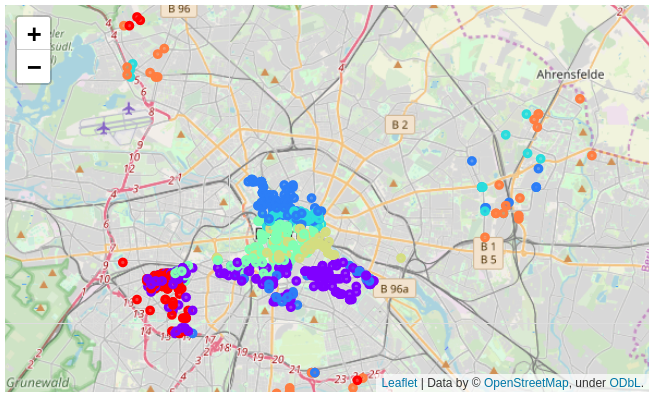

In [117]:
# Let's visualize companies that are similar in terms of venue category details
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters based on index numbers of grouped dataframe
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_data['Lat'], final_data['Lon'], final_data['Branch'], final_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
from IPython.display import Image
Image(filename="images/Similar types of companies.png")

In [126]:
final_data.loc[final_data['Cluster Labels'] == 0]

Name  1st Most Common Venue  \
11                               A.D. Real Estate GmbH     Italian Restaurant   
12                            A.D. Real Estate II GmbH     Italian Restaurant   
17                    AHA! Lernkonzepte Franchise GmbH                   Café   
19                                      AKS-Energie AG     Italian Restaurant   
28                            ARTUS REAL GmbH + Co. KG      German Restaurant   
37                      Abathon Knigge + Karriere GmbH                  Hotel   
52          Alcendo Gesellschaft für Finanzplanung mbH      German Restaurant   
54                        Allegra Grund und Boden GmbH            Supermarket   
56                  Alpha New Technology Services GmbH     Italian Restaurant   
59   Altmarkt 12 Grundstücks GmbH + Co. Verwaltungs KG                  Hotel   
60                        Altmarkt 12 Verwaltungs GmbH                  Hotel   
63                                 Anderson + Smith AG     Italian Restaurant   
68               AquaProject Distribution Germany GmbH     Italian Restaurant   
81                      Artus Apartments GmbH + Co. KG      German Restaurant   
97           BBM Blue Balanced Energy Manufactory GmbH     Italian Restaurant   
99                              BEFO-Berlin Forum e.K.                  Hotel   
100                                            BEOS AG     Italian Restaurant   
106  BIT GmbH Berliner Institut für Technologietran...                 Bakery   
110                                    BNI Berlin GmbH  Vietnamese Restaurant   
119       Baugenossenschaft Freie Scholle zu Berlin eG        Nature Preserve   
121           Baumgart Becker Planungsgesellschaft mbH     Italian Restaurant   
130                                    Berlin KGI GmbH                  Hotel   
131                        Berlin KGI II GmbH + Co. KG                  Hotel   
159                       CALIDRIS 28 Deutschland GmbH                  Hotel   
160                                         CAPAX GmbH      German Restaurant   
167                            CG Deutsche Wohnen GmbH     Italian Restaurant   
177                         CURA Hausnotrufdienst GmbH                  Hotel   
178        CURA Häuslicher Pflegedienst Oldenburg GmbH                  Hotel   
179      CURA Seniorencentrum Zeven Liegenschafts GmbH                  Hotel   
183                            Campus dell´ Anima GmbH                 Bakery   
188                                        Celron GmbH     Italian Restaurant   
204                                 Connex Campus GmbH     Italian Restaurant   
213                     D + O Assekuranz-Institut GmbH     Italian Restaurant   
216                                     DCH Solar GmbH      German Restaurant   
220  DGI Deutsche Gesellschaft für Informationssich...     Italian Restaurant   
235                   DPUW Deutsche Pflege + Wohnen AG     Italian Restaurant   
251                DianaDesign UG (haftungsbeschränkt)     Italian Restaurant   
252      Diaz + Hilterscheid Unternehmensberatung GmbH     Italian Restaurant   
261                          Dominart Real Estate GmbH     Italian Restaurant   
270           E + D Management UG (haftungsbeschränkt)     Italian Restaurant   
271                                 EB MASTERPLAN GMBH                  Hotel   
272                                 EB Spree-Loft GmbH                  Hotel   
280                          ESTAVIS Wohneigentum GmbH                  Hotel   
316                                   FV Property GmbH                  Hotel   
320                                       Feedify GmbH                  Hotel   
330                           Fortuna Verwaltungs GmbH     Italian Restaurant   
358                  GRUND UND BODEN Beteiligungs GmbH     Italian Restaurant   
359                  GRÜEZI Commercial Properties GmbH     Italian Restaurant   
360                 GRÜEZI Residential Properties GmbH     Italian Restaurant   


In [128]:
final_data.loc[final_data['Cluster Labels'] == 1]

Name 1st Most Common Venue  \
9                                         908video gmbh                   Bar   
15                         ADAPT Apartments Berlin GmbH           Coffee Shop   
18                                            AKM3 GmbH                   Bar   
30                         ASA Informationsdienste GmbH                   Bar   
34                                              AWIN AG     German Restaurant   
36                                           Abado GmbH                   Bar   
39                                     Abspannwerk GmbH                   Bar   
40               Accord Estates UG (haftungsbeschränkt)     German Restaurant   
49    Akademie für berufliche Weiterbildung AfbW Ber...                   Bar   
61                        Amore Automobile Moresco e.K.                   Bar   
66                         Anne Lampen Architekten GmbH                   Bar   
69    Aquarien Meyer Zoo-Shop im Gesundbrunnen-Cente...                   Bar   
83                                           Asisi GmbH                   Bar   
95                            BACHLER.Werbeagentur GmbH                   Bar   
111                          BOETHER RealtyPartner GmbH                   Bar   
117                                  Barketing IMS GmbH                   Bar   
125   Behnke + Pichler Rechtsanwälte in Partnerschaf...                   Bar   
128                                   Berlin Films GmbH     German Restaurant   
129                              Berlin Highlights GmbH     German Restaurant   
133   Berlin Plaza Hotel Hotelbetriebs- und Beratung...                   Bar   
134               Berlin-Brandenburg WelcomeCenter GmbH                   Bar   
136                                   Berlinerblau GmbH                   Bar   
157     Büroforum und Hotels Halle Dessau Betriebs GmbH                   Bar   
165                CD Facility Management GmbH + Co. KG                   Bar   
173                      CPI Celebrity Performance GmbH                  Café   
175   CSC. Cramer von Clausbruch Steinmeier + Cramer...                   Bar   
186                            Cazzo Film GmbH + Co. KG                   Bar   
192          Chesters Music Inn UG (haftungsbeschränkt)                   Bar   
195                                City.Stewardess GmbH                   Bar   
196                     ClinServices International GmbH                   Bar   
197                                   Club el.ele. GmbH                   Bar   
198                                    Coded Crush GmbH                   Bar   
203                                 Confiserie 2.0 GmbH                   Bar   
209                   Crown + Crown EventMarketing GmbH                   Bar   
232                              DOJO Werbeagentur GmbH                   Bar   
237                       DWW Deutsche Wahlwerbung GmbH           Coffee Shop   
244              Der grüne Shop UG (haftungsbeschränkt)                   Bar   
249        Deutschlandrockbasar UG (haftungsbeschränkt)                  Café   
255                   Die PC Techniker EDV Service GmbH           Coffee Shop   
256                              Die Reiseboutique GmbH                   Bar   
259                            Digital Performance GmbH                   Bar   
262                           Dorland Werbeagentur GmbH                   Bar   
269    Dörte Augsten Haus- + Grundstücksverwaltung GmbH           Coffee Shop   
285        EWB energywerk energieeffizienzvertrieb GmbH                   Bar   
287                         East London Restaurant e.K.                   Bar   
292                                   Effekt-Etage GmbH     German Restaurant   
303                                   Eventus Plus GmbH                   Bar   
304             Excellent Event UG (haftungsbeschränkt)                   Bar   
314                                    FS Fox-Shop GmbH                   Bar   
3

In [131]:
final_data.loc[final_data['Cluster Labels'] == 6]

Name 1st Most Common Venue  \
87                                      Auto Mivex GmbH           Supermarket   
88                                   Autohaus Koch GmbH           Supermarket   
89                       Autohaus Märkische Spitze GmbH           Supermarket   
90                           Autohaus Wittestrasse GmbH           Supermarket   
120                          Baugenossenschaft IDEAL eG           Supermarket   
122                                         BeQuMA GmbH           Supermarket   
152                                        BrasTec GmbH           Supermarket   
190                                CheapTickets.de GmbH           Supermarket   
206                      Convergys Global Services GmbH           Supermarket   
241         DefiMED Lebensrettung durch Sponsoring GmbH          Tram Station   
242                                      Dekamedia GmbH           Supermarket   
284                                  EUROVIA Infra GmbH          Tram Station   
313                      FORTUNA Wohnungsunternehmen eG           Supermarket   
342                      GEA Refrigeration Germany GmbH           Supermarket   
349                 GLS Gleis - Logistik - Service GmbH           Supermarket   
412                   H. W. Auto-Zentrum-Adlershof GmbH           Supermarket   
414   HD Factory Berlin Gesellschaft für Film- + TV-...           Supermarket   
454                  Horizont Wohnungsgenossenschaft eG           Supermarket   
555                           Koch Gruppe Automobile AG           Supermarket   
582                        Leibao Germany Ltd. + Co. KG           Supermarket   
593                                Lorenz Akademie GmbH          Tram Station   
600              MA-NIC Dienstleistungsgesellschaft mbH           Supermarket   
615          MURECON German Real Estate Consulting GmbH          Tram Station   
625                   MeCoStore Handelsgesellschaft mbH           Supermarket   
659                                    Nitz + Nitz GmbH              Bus Stop   
671                   OPITZ CONSULTING Deutschland GmbH           Supermarket   
721                             Peppermint Holding GmbH         Train Station   
765                              SOLON Investments GmbH           Supermarket   
801     TWD - team: Werbedesign UG (haftungsbeschränkt)           Supermarket   
835                   Volkswagen Automobile Berlin GmbH           Supermarket   
850              Wohnungsgenossenschaft FRIEDENSHORT eG           Supermarket   
860   Zahnklinik Ost Verwaltung UG (haftungsbeschränkt)           Supermarket   
863                                    active4jobs GmbH           Supermarket   
873                                         assona GmbH           Supermarket   
884         bitap media-systems UG (haftungsbeschränkt)           Supermarket   
891                                        budatec GmbH           Supermarket   
921                   eci.media UG (haftungsbeschränkt)           Supermarket   
943                                          hosho GmbH           Supermarket   
956                                       infrasis GmbH           Supermarket   
958                              inolares GmbH + Co. KG          Tram Station   
1006                     perfect timing geosystems GmbH           Supermarket   
1023                                      tv 4 you GmbH              Bus Stop   
1027                        walter services Berlin GmbH              Bus Stop   

            2nd Most Common Venue 3rd Most Common Venue  \
87                         Bakery              Bus Stop   
88                Auto Dealership  Gym / Fitness Center   
89                   Tram Station                 Hotel   
90    Eastern European Restaurant           Gas Station   
120                      Bus Stop                Bakery   
122              Indoor Play Area             Drugstore   
152                      Bus Stop    Light Rail Station   
190           